In [220]:
#inverse delta range et delta std .1 <-> .5
#range .5 and std to 1
#fix delta rerun 2
# free rdl rais lr -2 <- -3 rerun 2
# change range to sqrt rerun all

In [221]:
%matplotlib inline

In [222]:
import time

import os
import pickle # to save synthetic_data_prior object
import numpy as np
import torch
print("Torch version: "+torch.__version__)
from torch.autograd import Variable
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print("GPU usage.")
else:
    dtype = torch.FloatTensor
    print("CPU usage.")

    ## Copyright 2018 Maurizio Filippone
##
## Licensed under the Apache License, Version 2.0 (the "License");
## you may not use this file except in compliance with the License.
## You may obtain a copy of the License at
##
##     http://www.apache.org/licenses/LICENSE-2.0
##
## Unless required by applicable law or agreed to in writing, software
## distributed under the License is distributed on an "AS IS" BASIS,
## WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
## See the License for the specific language governing permissions and
## limitations under the License.


#  This class implements a Deep Gaussian process model approximated using random features and infered using mini-batch
#  stochastic variational inference. The model is constructed as a torch.nn.Module.

import os.path # only for saveStates
import pickle # only for saveStates
import numpy as np
import torch

from torch.autograd import Variable

import core.utilities as utilities

import core.likelihoods  as likelihoods


class nn_layer(torch.nn.Module):
        def __init__(self, Din, Dout, NRFs, kernel, kernel_ard, factorized, learn_Omega, learn_hyperparam, add_mean, 
                 local_reparameterization, dtype,seedForOmega=None):
            super(nn_layer, self).__init__()
            self.Din = Din
            self.Dout = Dout
            self.NRFs = NRFs
            self.kernel = kernel
            self.kernel_ard = kernel_ard
            self.factorized = factorized
            self.learn_Omega = learn_Omega
            self.learn_hyperparam = learn_hyperparam
            self.add_mean = add_mean
            self.local_reparameterization = local_reparameterization
            self.dtype = dtype
            if self.learn_hyperparam == "optim":
                    self.log_sigma2 = torch.nn.Parameter((0.02**2*torch.ones(1, 1)).log().type(self.dtype), requires_grad=True)
                    if not kernel_ard:
                            self.log_lengthscale = torch.nn.Parameter((0.27*torch.ones(1, 1)).log().type(self.dtype),requires_grad=True)
                    if kernel_ard:
                        self.log_lengthscale = torch.nn.Parameter(
                            torch.ones(self.Din,1).type(self.dtype) * 0.5 * np.log((self.Din) * 1.0) - np.log(2.0),
                            requires_grad=True)  # Initialize lengthscale to sqrt(D) / 2
                    # If random features are fixed from the prior we fix the randomness - the lengthscale
                    # will be learnt using the reparameterization trick
            if self.learn_Omega == "prior_fixed":
                        if seedForOmega is not None:
                            torch.manual_seed(seedForOmega)
                        self.epsilon_for_Omega_sample = Variable(torch.randn(self.Din, self.NRFs).type(self.dtype),
                                                                 requires_grad=False)
                        # TODO : If random features are learned variationally, we learn the approximate
                    # posterior q(Omega) fixing the randomness 
                    #if self.learn_Omega == "var_fixed":
                    #    self.epsilon_for_Omega_sample = Variable(torch.randn(1, self.Din, self.NRFs).type(self.dtype),
                    #                                             requires_grad=False)

                    #    self.q_Omega_m = torch.nn.Parameter(torch.zeros(self.Din, self.NRFs).type(self.dtype),
                    #                                        requires_grad=True)
                    #    self.q_Omega_logv = torch.nn.Parameter(
                    #        torch.ones(self.Din, self.NRFs).type(self.dtype) * -2.0 * self.log_theta_lengthscale.data,
                    #        requires_grad=True)  # We initialize q(Omega) as p(Omega)

                # Prior over Omega will be defined in the forward to make it depend explicitly on the lengthscale

                # Prior and posterior over W
            self.dimension_correction_factor = 1
            self.dimension_correction_add = 0
                # In the rbf case, we need to double the size of W because Phi is obtained
                # by concatenating sin(X Omega) and cos(X Omega)
            if self.kernel == "rbf":
                 self.dimension_correction_factor = 2
            if self.add_mean:
                 self.dimension_correction_add = self.Din

                ## ********** Prior and posterior over W
                ## -- Mean
            self.prior_W_m = Variable(torch.zeros(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                      self.Dout).type(self.dtype), requires_grad=False)
            self.q_W_m = torch.nn.Parameter(torch.zeros_like(self.prior_W_m.data).type(self.dtype), requires_grad=True)

            if self.add_mean:
                    ## The first block of W will contain the parameters of the linear model for the mean function of the GP
                    ## Put the prior over W to mean = 1 for the parameters of the linear part - similar to residual-net idea
                    self.prior_W_m = Variable(torch.eye(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                            self.Dout).type(self.dtype), requires_grad=False)

                    self.q_W_m = torch.nn.Parameter(torch.eye(self.prior_W_m.shape[0], self.prior_W_m.shape[1]).type(self.dtype), requires_grad=True)

                ## -- Variance/Covariance
            self.prior_W_logv = Variable(torch.zeros(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                         self.Dout).type(self.dtype), requires_grad=False)
            #TODO: non factorized prior
            if self.factorized:
                self.q_W_logv = torch.nn.Parameter(torch.zeros_like(self.prior_W_logv.data).type(self.dtype), requires_grad=True)

        def predict(self,X,Nmc):# X is Nmc x n x dout
            Omega_sample = torch.exp(-self.log_lengthscale)*2.**0.5*self.epsilon_for_Omega_sample
            Phi_before_activation = torch.matmul(X, Omega_sample)
            # Forward computation of F # TODO: save computation if Phi doesn't not change during optim
            if self.kernel == "rbf":
                self.Phi_noStd = torch.cat((torch.sin(Phi_before_activation), torch.cos(Phi_before_activation)), 2)
            Phi = self.Phi_noStd * torch.sqrt(torch.exp(self.log_sigma2) / self.NRFs)
            mean_F = torch.matmul(Phi, self.q_W_m)
            var_F = torch.matmul(Phi**2, torch.exp(self.q_W_logv))
            epsilon_for_F_sample   = Variable(torch.randn(Nmc, Phi.shape[1]  , self.Dout).type(self.dtype), requires_grad=False)
            return epsilon_for_F_sample*torch.sqrt(var_F)+mean_F
           
class calib_GP_RFs_SVI_layer(torch.nn.Module):
        def __init__(self, D1, D2, Dout, NRFs, kernel, kernel_ard, factorized, learn_Omega, learn_hyperparam, add_mean, 
                 local_reparameterization, dtype,priorThetaMean=None,priorThetaCovRoot=None,seedForOmega=None,additiveDiscr=True):
            super(calib_GP_RFs_SVI_layer, self).__init__()
            self.D1 = D1
            self.D2 = D2
            self.Dout = Dout
            self.NRFs = NRFs
            self.kernel = kernel
            self.kernel_ard = kernel_ard
            self.factorized = factorized
            self.learn_Omega = learn_Omega
            self.learn_hyperparam = learn_hyperparam
            self.add_mean = add_mean
            self.local_reparameterization = local_reparameterization
            self.dtype = dtype
            self.additiveDiscr = additiveDiscr

            if self.learn_hyperparam == "optim":
                    self.log_eta_sigma2 = torch.nn.Parameter((0.02**2*torch.ones(1, 1)).log().type(self.dtype), requires_grad=True)
                    self.log_delta_sigma2 = torch.nn.Parameter((0.002**2*torch.ones(1, 1)).log().type(self.dtype), requires_grad=True)
                    if not kernel_ard:
                            self.log_eta_lengthscale = torch.nn.Parameter((0.27*torch.ones(1, 1)).log().type(self.dtype),requires_grad=True)
                            self.log_delta_lengthscale = torch.nn.Parameter((0.1*torch.ones(1, 1)).log().type(self.dtype),requires_grad=True)
                    if kernel_ard:
                        self.log_eta_lengthscale = torch.nn.Parameter(
                            torch.ones(self.D1+self.D2,1).type(self.dtype) * 0.5 * np.log((self.D1+self.D2) * 1.0) - np.log(2.0),
                            requires_grad=True)  # Initialize lengthscale to sqrt(D) / 2
                        if additiveDiscr:
                            self.log_delta_lengthscale = torch.nn.Parameter(
                                torch.ones(self.D1,1).type(self.dtype) * 0.5 * np.log(self.D1 * 1.0) - np.log(2.0),
                                requires_grad=True)  # Initialize lengthscale to sqrt(D) / 2
                        else:
                            self.log_delta_lengthscale = torch.nn.Parameter(
                                torch.ones(self.D1+1,1).type(self.dtype) * 0.5 * np.log((self.D1+1) * 1.0) - np.log(2.0),
                                requires_grad=True)  # Initialize lengthscale to sqrt(D) / 2
                    # If random features are fixed from the prior we fix the randomness - the lengthscale
                    # will be learnt using the reparameterization trick
            if self.learn_Omega == "prior_fixed":
                        if seedForOmega is not None:
                            torch.manual_seed(seedForOmega)
                        self.epsilon_for_Omega_eta_sample = Variable(torch.randn(self.D1+self.D2, self.NRFs).type(self.dtype),
                                                                 requires_grad=False)
                        if additiveDiscr:
                            self.epsilon_for_Omega_delta_sample = Variable(torch.randn(self.D1, self.NRFs).type(self.dtype),
                                                                 requires_grad=False)
                        else:
                            self.epsilon_for_Omega_delta_sample = Variable(torch.randn(self.D1+self.Dout, self.NRFs).type(self.dtype),
                                                                 requires_grad=False)
                            self.etaAnisotropy = torch.nn.Parameter(torch.ones(1).log().type(self.dtype), requires_grad=True)
                            
                        # TODO : If random features are learned variationally, we learn the approximate
                    # posterior q(Omega) fixing the randomness 
                    #if self.learn_Omega == "var_fixed":
                    #    self.epsilon_for_Omega_sample = Variable(torch.randn(1, self.Din, self.NRFs).type(self.dtype),
                    #                                             requires_grad=False)

                    #    self.q_Omega_m = torch.nn.Parameter(torch.zeros(self.Din, self.NRFs).type(self.dtype),
                    #                                        requires_grad=True)
                    #    self.q_Omega_logv = torch.nn.Parameter(
                    #        torch.ones(self.Din, self.NRFs).type(self.dtype) * -2.0 * self.log_theta_lengthscale.data,
                    #        requires_grad=True)  # We initialize q(Omega) as p(Omega)

                # Prior over Omega will be defined in the forward to make it depend explicitly on the lengthscale

                # Prior and posterior over W
            self.dimension_correction_factor = 1
            self.dimension_correction_add = 0
                # In the rbf case, we need to double the size of W because Phi is obtained
                # by concatenating sin(X Omega) and cos(X Omega)
            if self.kernel == "rbf":
                 self.dimension_correction_factor = 2
            if self.add_mean:
                 self.dimension_correction_add = self.D1+self.D2

                ## ********** Prior and posterior over W
                ## -- Mean
            self.prior_W_eta_m = Variable(torch.zeros(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                      self.Dout).type(self.dtype), requires_grad=False)
            self.prior_W_delta_m = Variable(torch.zeros(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                      self.Dout).type(self.dtype), requires_grad=False)
            self.q_W_eta_m = torch.nn.Parameter(torch.zeros_like(self.prior_W_eta_m.data).type(self.dtype), requires_grad=True)
            self.q_W_delta_m = torch.nn.Parameter(torch.zeros_like(self.prior_W_delta_m.data).type(self.dtype), requires_grad=True)

            if self.add_mean:
                    ## The first block of W will contain the parameters of the linear model for the mean function of the GP
                    ## Put the prior over W to mean = 1 for the parameters of the linear part - similar to residual-net idea
                    self.prior_W_eta_m = Variable(torch.eye(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                            self.Dout).type(self.dtype), requires_grad=False)
                    self.prior_W_delta_m = Variable(torch.eye(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                            self.Dout).type(self.dtype), requires_grad=False)

                    self.q_W_eta_m = torch.nn.Parameter(torch.eye(self.prior_W_m.shape[0], self.prior_W_m.shape[1]).type(self.dtype), requires_grad=True)
                    self.q_W_delta_m = torch.nn.Parameter(torch.eye(self.prior_W_m.shape[0], self.prior_W_m.shape[1]).type(self.dtype), requires_grad=True)
            if (priorThetaMean is not None):
                self.prior_theta_m = Variable(priorThetaMean, requires_grad=False)
            else:
                self.prior_theta_m = Variable(torch.zeros(D2).type(self.dtype), requires_grad=False)
            self.q_theta_m = torch.nn.Parameter(self.prior_theta_m.data.clone(), requires_grad=True)
                ## -- Variance/Covariance
            self.prior_W_eta_logv = Variable(torch.zeros(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                         self.Dout).type(self.dtype), requires_grad=False)
            self.prior_W_delta_logv = Variable(torch.zeros(self.NRFs * self.dimension_correction_factor + self.dimension_correction_add, 
                                                         self.Dout).type(self.dtype), requires_grad=False)
            #TODO: non factorized prior
            if self.factorized:
                if (priorThetaCovRoot is not None):
                    self.prior_theta_logv = Variable((torch.diag(priorThetaCovRoot)**2).log().type(self.dtype), requires_grad=False)
                else :
                    self.prior_theta_logv = Variable((0.1**2*torch.ones(D2)).log().type(self.dtype), requires_grad=False)
                self.q_W_eta_logv = torch.nn.Parameter(torch.zeros_like(self.prior_W_eta_logv.data).type(self.dtype), requires_grad=True)
                self.q_W_delta_logv = torch.nn.Parameter(torch.zeros_like(self.prior_W_delta_logv.data).type(self.dtype), requires_grad=True)
            self.q_theta_logv = torch.nn.Parameter(self.prior_theta_logv.data.clone(), requires_grad=True)

        def predictGivenTheta(self,X,XStar,T,Nmc,theta_sample=None,forcePhiCompute=False):
            if (self.learn_Omega == "prior_fixed"):
                if (not self.log_eta_lengthscale.requires_grad):
                    computePhiEta_computerCode = False
                    if forcePhiCompute:
                        computePhiEta_computerCode = True
                else:
                    computePhiEta_computerCode = True
                if (not self.log_delta_lengthscale.requires_grad):
                    computePhiDelta = False
                    if forcePhiCompute:
                        computePhiDelta = True
                        Omega_delta_sample = torch.exp(-self.log_delta_lengthscale)*2.**0.5*self.epsilon_for_Omega_delta_sample
                else:
                    computePhiDelta = True
                    Omega_delta_sample = torch.exp(-self.log_delta_lengthscale)*2.**0.5*self.epsilon_for_Omega_delta_sample
                ## NB: Omega_eta_sample is always computed even with fixed lengthscale because of random theta
                Omega_eta_sample = torch.exp(-self.log_eta_lengthscale)*2.**0.5*self.epsilon_for_Omega_eta_sample
            if theta_sample is None:
                epsilon_for_theta_sample = Variable(torch.randn(Nmc, self.D2).type(self.dtype), requires_grad=False)
                if self.factorized:
                    theta_sample = torch.add(torch.mul(epsilon_for_theta_sample, torch.exp(self.q_theta_logv / 2.0)), self.q_theta_m)
            XthetaRep = torch.cat(((X.unsqueeze(0)).expand(Nmc,-1,-1),theta_sample.unsqueeze(1).expand(-1,X.size()[0],-1)),2)

            Phi_eta_before_activation = torch.matmul(XthetaRep, Omega_eta_sample)
            if computePhiEta_computerCode:
                Phi_eta_before_activation_computerCode = torch.mm(torch.cat((XStar,T),1),Omega_eta_sample)
            # Forward computation of F # TODO: save computation if Phi doesn't not change during optim
            if self.kernel == "rbf":
                self.Phi_eta_noStd = torch.cat((torch.sin(Phi_eta_before_activation), torch.cos(Phi_eta_before_activation)), 2)
                if computePhiEta_computerCode:
                    self.Phi_eta_computerCode_noStd = torch.cat((torch.sin(Phi_eta_before_activation_computerCode), torch.cos(Phi_eta_before_activation_computerCode)), 1)
                else:
                    self.Phi_eta_computerCode_noStd = self.Phi_eta_computerCode_noStd.detach()
            Phi_eta = self.Phi_eta_noStd * torch.sqrt(torch.exp(self.log_eta_sigma2) / self.NRFs)
            Phi_eta_computerCode = self.Phi_eta_computerCode_noStd * torch.sqrt(torch.exp(self.log_eta_sigma2) / self.NRFs)
            mean_F_eta = torch.matmul(Phi_eta, self.q_W_eta_m)
            var_F_eta = torch.matmul(Phi_eta**2, torch.exp(self.q_W_eta_logv))
            mean_F_eta_computerCode = torch.matmul(Phi_eta_computerCode, self.q_W_eta_m)
            var_F_eta_computerCode = torch.matmul(Phi_eta_computerCode**2, torch.exp(self.q_W_eta_logv))
            if computePhiDelta:
                if self.additiveDiscr:
                    Phi_delta_before_activation = torch.matmul(XthetaRep[:,:,0:(self.D1)], Omega_delta_sample)
                else:
                    epsilon_for_F_eta_sample = Variable(torch.randn(Nmc, XthetaRep.size()[1],self.Dout).type(self.dtype), requires_grad=False)
                    F_eta_sample =epsilon_for_F_eta_sample*var_F_eta.sqrt()+ mean_F_eta
                    Phi_delta_before_activation = torch.matmul(torch.cat((self.etaAnisotropy.exp()*(F_eta_sample),XthetaRep[:,:,0:(self.D1)]),2), Omega_delta_sample)#s
            if self.kernel == "rbf":
                if computePhiDelta:
                    self.Phi_delta_noStd = torch.cat((torch.sin(Phi_delta_before_activation), torch.cos(Phi_delta_before_activation)), 2)
                else:
                    self.Phi_delta_noStd = self.Phi_delta_noStd.detach()
            Phi_delta = self.Phi_delta_noStd * torch.sqrt(torch.exp(self.log_delta_sigma2) / self.NRFs)
            mean_F_delta = torch.matmul(Phi_delta, self.q_W_delta_m)
            var_F_delta = torch.matmul(Phi_delta**2, torch.exp(self.q_W_delta_logv))
            return mean_F_eta+mean_F_delta, var_F_eta+var_F_delta,mean_F_eta_computerCode,var_F_eta_computerCode
        
        
        def predictGivenThetaRep(self,XthetaRep,XStarT,Nmc):
            if (self.learn_Omega == "prior_fixed"):
                Omega_delta_sample = torch.exp(-self.log_delta_lengthscale)*2.**0.5*self.epsilon_for_Omega_delta_sample
                Omega_eta_sample = torch.exp(-self.log_eta_lengthscale)*2.**0.5*self.epsilon_for_Omega_eta_sample
            Phi_eta_before_activation = torch.matmul(XthetaRep, Omega_eta_sample)
            Phi_eta_before_activation_computerCode = torch.matmul(XStarT,Omega_eta_sample)
            # Forward computation of F # TODO: save computation if Phi doesn't not change during optim
            if self.kernel == "rbf":
                self.Phi_eta_noStd = torch.cat((torch.sin(Phi_eta_before_activation), torch.cos(Phi_eta_before_activation)), 2)
                self.Phi_eta_computerCode_noStd = torch.cat((torch.sin(Phi_eta_before_activation_computerCode), torch.cos(Phi_eta_before_activation_computerCode)), 2)
            Phi_eta = self.Phi_eta_noStd * torch.sqrt(torch.exp(self.log_eta_sigma2) / self.NRFs)
            Phi_eta_computerCode = self.Phi_eta_computerCode_noStd * torch.sqrt(torch.exp(self.log_eta_sigma2) / self.NRFs)
            mean_F_eta = torch.matmul(Phi_eta, self.q_W_eta_m)
            var_F_eta = torch.matmul(Phi_eta**2, torch.exp(self.q_W_eta_logv))
            mean_F_eta_computerCode = torch.matmul(Phi_eta_computerCode, self.q_W_eta_m)
            var_F_eta_computerCode = torch.matmul(Phi_eta_computerCode**2, torch.exp(self.q_W_eta_logv))
            
            if self.additiveDiscr:
                Phi_delta_before_activation = torch.matmul(XthetaRep[:,:,0:(self.D1)], Omega_delta_sample)
            else:
                epsilon_for_F_eta_sample = Variable(torch.randn(Nmc, XthetaRep.size()[1],self.Dout).type(self.dtype), requires_grad=False)
                F_eta_sample =epsilon_for_F_eta_sample*var_F_eta.sqrt()+ mean_F_eta
                Phi_delta_before_activation = torch.matmul(torch.cat((self.etaAnisotropy.exp()*(F_eta_sample),XthetaRep[:,:,0:(self.D1)]),2), Omega_delta_sample)#s

            if self.kernel == "rbf":
                self.Phi_delta_noStd = torch.cat((torch.sin(Phi_delta_before_activation), torch.cos(Phi_delta_before_activation)), 2)

            Phi_delta = self.Phi_delta_noStd * torch.sqrt(torch.exp(self.log_delta_sigma2) / self.NRFs)


            mean_F_delta = torch.matmul(Phi_delta, self.q_W_delta_m)
            var_F_delta = torch.matmul(Phi_delta**2, torch.exp(self.q_W_delta_logv))

            return mean_F_eta+mean_F_delta, var_F_eta+var_F_delta,mean_F_eta_computerCode,var_F_eta_computerCode
        
     
# ****************************** Define model as a nn module
class calib_GP_RFs_SVI(torch.nn.Module):
    def __init__(self, D1,D2, Dout, NRFs, batch_size, kernel, kernel_ard, factorized, learn_Omega, learn_hyperparam, likelihood, add_mean, local_reparameterization,
                 dtype,priorThetaMean=None,priorThetaCovRoot=None,seedForOmega=None,nn_layers=None,additiveDiscr=True):
        super(calib_GP_RFs_SVI, self).__init__()
        self.D1 = D1
        self.D2 = D2
        self.Dout = Dout
        self.NRFs = NRFs
        self.batch_size = batch_size
        self.kernel = kernel
        self.kernel_ard = kernel_ard
        self.factorized = factorized
        self.learn_Omega = learn_Omega
        self.learn_hyperparam = learn_hyperparam
        self.likelihood_name = likelihood
        self.add_mean = add_mean
        self.local_reparameterization = local_reparameterization
        self.dtype = dtype
        self.log_2_pi_torch = Variable(torch.ones(1), requires_grad=False).type(dtype) * np.log(
            2.0 * np.pi)

        # Create model as a nn.ModuleList - syntax requires += of a list with any layers that need to be added
        # TODO!! Look into nn.Sequential as it might be the easiest way to concatenate layers!

        self.layers = torch.nn.ModuleList()

        self.layers += [
                calib_GP_RFs_SVI_layer(self.D1,self.D2, self.Dout, self.NRFs, self.kernel, self.kernel_ard, self.factorized, self.learn_Omega, 
                self.learn_hyperparam, self.add_mean, self.local_reparameterization, self.dtype,priorThetaMean,priorThetaCovRoot,seedForOmega=seedForOmega,additiveDiscr=additiveDiscr)]
        if nn_layers is None:
            self.deepness= 0
        else:
            self.deepness= len(nn_layers)
        if nn_layers is not None:
            self.layers += nn_layers

        if self.likelihood_name == "gaussian":
            # We define the variance of the noise here instead of the nested class to make it easy
            # to optimize all model parameters using the torch.nn module
            self.log_Y_noise_var = torch.nn.Parameter((torch.ones(self.Dout) * 0.1**2).log(), requires_grad=True)
            self.log_Z_noise_var = torch.nn.Parameter((torch.ones(self.Dout) * 0.1**2).log(), requires_grad=True)
            self.likelihood = likelihoods.Gaussian(self)

        if self.likelihood_name == "softmax":
            self.likelihood = likelihoods.Softmax()

    # Define forward computation throughout the layers
    def forward(self, X,XStar,T, Nmc):
        if self.deepness>0:
            epsilon_for_theta_sample = Variable(torch.randn(Nmc, self.D2).type(self.dtype), requires_grad=False)
            if self.layers[0].factorized:
                theta_sample = torch.add(torch.mul(epsilon_for_theta_sample, torch.exp(self.layers[0].q_theta_logv / 2.0)), self.layers[0].q_theta_m)  
            XthetaRep = torch.cat(((X.unsqueeze(0)).expand(Nmc,-1,-1),theta_sample.unsqueeze(1).expand(-1,X.size()[0],-1)),2)
            XStarT = torch.cat((XStar,T),1).unsqueeze(0).expand(Nmc,-1,-1)
            for i in range(self.deepness):
                XthetaRep = self.layers[i+1].predict(XthetaRep,Nmc)
                XStarT = self.layers[i+1].predict(XStarT,Nmc)
            meanYGivenTheta,varYGivenTheta,meanZGivenTheta,varZGivenTheta =  self.layers[0].predictGivenThetaRep(XthetaRep, XStarT, Nmc)
        else:
            meanYGivenTheta,varYGivenTheta,meanZGivenTheta,varZGivenTheta =  self.layers[0].predictGivenTheta(X, XStar, T, Nmc,theta_sample=None,forcePhiCompute=True)
        return meanYGivenTheta,varYGivenTheta,meanZGivenTheta,varZGivenTheta

    ## Computation of the negative expected log-likelihood
    def compute_nell(self, X, XStar, T, Y, Z, Nmc, n, N, batch_size,batch_sizeY=None):

        if batch_sizeY is None:
            batch_sizeY=n
        
        meanYGivenTheta,varYGivenTheta,meanZGivenTheta,varZGivenTheta = self.forward(X,XStar,T, Nmc)
            #latent_valY,latent_valZ =  self.forward(X, XStar, T, Nmc)
            #likelY = - 0.5 * (n*(self.log_2_pi_torch+self.log_Y_noise_var) + ((Y-latent_valY)**2).sum(1) * torch.exp(-self.log_Y_noise_var))
        likelY = - 0.5 * (n*(self.log_2_pi_torch+self.log_Y_noise_var) + (Y**2-2*Y*meanYGivenTheta+varYGivenTheta+meanYGivenTheta**2).sum(1) * torch.exp(-self.log_Y_noise_var))
        nellY  = - n/batch_sizeY*torch.mean(likelY, 0)
        if self.deepness>0:
            likelZ = - 0.5 * (batch_size*(self.log_2_pi_torch+self.log_Z_noise_var) + (Z**2-2*Z*meanZGivenTheta+varZGivenTheta+meanZGivenTheta**2).sum(1) * torch.exp(-self.log_Z_noise_var))
            nellZ  = - N / batch_size * torch.mean(likelZ, 0)
        
        else:
            #likelZ  = - 0.5 * (batch_size*(self.log_2_pi_torch+self.log_Z_noise_var) + ((Z-latent_valZ)**2).sum(1) * torch.exp(-self.log_Z_noise_var))
            likelZ = - 0.5 * (batch_size*(self.log_2_pi_torch+self.log_Z_noise_var) + (Z**2-2*Z*meanZGivenTheta+varZGivenTheta+meanZGivenTheta**2).sum(0) * torch.exp(-self.log_Z_noise_var))
            #nellZ  = - N / batch_size * torch.mean(likelZ, 0)
            nellZ  = - N / batch_size * likelZ
            
        self.nell = (nellY + nellZ)
        return self.nell
        
    ## Computation of the DKL
    def compute_dkl(self):
        ## DKL
        self.dkl = 0
        # DKL for W
        if self.factorized:
            self.dkl += utilities.DKL_gaussian_q_diag_p_diag(self.layers[0].q_W_eta_m, self.layers[0].q_W_eta_logv, self.layers[0].prior_W_eta_m, self.layers[0].prior_W_eta_logv)
            self.dkl += utilities.DKL_gaussian_q_diag_p_diag(self.layers[0].q_W_delta_m, self.layers[0].q_W_delta_logv, self.layers[0].prior_W_delta_m, self.layers[0].prior_W_delta_logv)
        if self.deepness > 0:
            for i in range(self.deepness):
                self.dkl += utilities.DKL_gaussian_q_diag_p_diag(self.layers[i+1].q_W_m, self.layers[i+1].q_W_logv, self.layers[i+1].prior_W_m, self.layers[i+1].prior_W_logv)
        # DKL for Omega if necessary
        #if self.learn_Omega == "var_fixed":
        #    for i in range(self.Nlayers):
        #        self.dkl += utilities.DKL_gaussian_q_diag_p_diag(self.layers[i].q_Omega_m, self.layers[i].q_Omega_logv,
        #                                                         self.layers[i].prior_Omega_m,
        #self.layers[i].prior_Omega_logv)
        # DKL for theta
        if self.factorized:
            self.dkl += utilities.DKL_gaussian_q_diag_p_diag(self.layers[0].q_theta_m, self.layers[0].q_theta_logv,
                                                                  self.layers[0].prior_theta_m, self.layers[0].prior_theta_logv)    
        return self.dkl

    ## Computation of the NELBO
    def compute_nelbo(self,X,XStar,T, Y, Z, Nmc, n, N, batch_size,batch_sizeY=None):
        self.nelbo =  self.compute_nell(X,XStar,T, Y, Z, Nmc, n, N, batch_size,batch_sizeY) + self.compute_dkl()
        return self.nelbo

    ## Learn
    def learn(self, X, XStar, T, Y, Z, n, N, Nmc_train, batch_size, XTtest, YZtest, Ntest, Nmc_test,
              verbose=5,learning_rate=10**(-3),optimisationDescription=None,saveStates=None,batch_sizeY=None,displayZlearn=False,displayYlearn=False,displayDef=False):

        
        
        if (optimisationDescription is None):
            optimisationDescription = torch.zeros(1,18)
        #0 nIt 1learning,2"NLB",3"NLL",4"DKL", 5grad norm,6"NsY",7"NsZ",8"Ret",9Set",10"Rdl",11"Sdl",12"Mth",13"Sth"
        paraNames = ["Lrt","NLB","NLL","DKL","GdN","NsY","NsZ","Ret","Set","Rdl","Sdl","Mth","Sth","MWE","SWE","MWD","SWD"] 
        
        if self.batch_size > N:
            print("Warning: you selected batch_size > N - the batch size will be reduced to N\n\n")
            self.batch_size = N
        def displayLine(st,t,optimisationDescription,header=True,saveStates=None):
            Niterations = optimisationDescription[st,0]
            nbDisplaThetam = int(np.min([((self.layers[0].q_theta_m.data)).size()[0],8]))
            if header:
                headerLine = " Ite | % |"
                for i in range(17):
                    if (optimisationDescription[st,i+1]%2==0):
                        if (i==11):
                            for k in range(nbDisplaThetam):
                                headerLine += "   "+paraNames[i]+"   |"
                        else:
                            headerLine = headerLine+"   "+paraNames[i]
                            if i<16:
                                headerLine+="   |"
                print(headerLine)
            model_grad_val = 0
            if (not (t==0 and st==0)):
                model_grad = filter(lambda p: p.requires_grad, self.parameters())
                #totalGrad = torch.zeros(0)
                model_grad_val=0
                for j in model_grad:
                    if j.grad is not None:
                        model_grad_val = model_grad_val+(j.grad.data**2).sum()
                    #totalGrad = torch.cat((totalGrad,j.grad.data.squeeze()),0)
                    #print(j.grad.data.squeeze())
                #print(model_grad_val)
            myStr = ""
            collect = [st]
            myStrAdd = "%5.0f" % t
            collect += [t]
            myStr += myStrAdd+"|"
            myStrAdd = "%3.0f" % (float(100*t)/float(Niterations))
            collect += [float(100*t)/float(Niterations)]
            myStr += myStrAdd+"|"
            if (optimisationDescription[st,1]%2==0):
                myStrAdd = "%9.3f" % self.learning_rate
                myStr += myStrAdd+"|"
                collect += [self.learning_rate]
            if (optimisationDescription[st,2]%2==0):
                myStrAdd = "%9.3f" % loss.data.item()
                myStr += myStrAdd+"|"
                collect += [loss.data.item()]
            if (optimisationDescription[st,3]%2==0):
                myStrAdd = "%9.3f" % self.nell.data.item()
                myStr += myStrAdd+"|"
                collect += [self.nell.data.item()]
            if (optimisationDescription[st,4]%2==0):
                myStrAdd = "%9.3f" % self.dkl.data.item()
                myStr += myStrAdd+"|"
                collect += [self.dkl.data.item()]
            if (optimisationDescription[st,5]%2==0):
                myStrAdd = "%9.3f" % model_grad_val
                myStr += myStrAdd+"|"
                collect += [float(model_grad_val)]
            if (optimisationDescription[st,6]%2==0):
                myStrAdd = "%9.3f" % ((self.log_Y_noise_var.data/2).exp()).item()
                myStr += myStrAdd+"|"
                collect += [float(((self.log_Y_noise_var.data/2).exp()).item())]
            if (optimisationDescription[st,7]%2==0):
                myStrAdd = "%9.3f" % ((self.log_Z_noise_var.data/2).exp()).item()
                myStr += myStrAdd+"|"
                collect += [float(((self.log_Z_noise_var.data/2).exp()).item())]
            if (optimisationDescription[st,8]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].log_eta_lengthscale.data).exp().mean(0)).item()
                myStr += myStrAdd+"|"
                collect += [float(((self.layers[0].log_eta_lengthscale.data).exp().mean(0)).item())]
            if (optimisationDescription[st,9]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].log_eta_sigma2.data/2).exp()).item()
                myStr += myStrAdd+"|"
                collect += [float(((self.layers[0].log_eta_sigma2.data/2).exp()).item())]
            if (optimisationDescription[st,10]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].log_delta_lengthscale.data).exp().mean(0)).item()
                myStr += myStrAdd+"|"
                collect += [float(((self.layers[0].log_delta_lengthscale.data).exp().mean(0)).item())]
            if (optimisationDescription[st,11]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].log_delta_sigma2.data/2).exp()).item()
                myStr += myStrAdd+"|"
                collect += [float(((self.layers[0].log_delta_sigma2.data/2).exp()).item())]
            if (optimisationDescription[st,12]%2==0):
                for k in range(nbDisplaThetam):
                    myStrAdd = "%9.3f" % ((self.layers[0].q_theta_m.data))[k]
                    myStr += myStrAdd+"|"
                    collect += [((self.layers[0].q_theta_m.data))[k]]
            if (optimisationDescription[st,13]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].q_theta_logv.data/2).exp()).mean()
                myStr += myStrAdd+"|"
                collect += [((self.layers[0].q_theta_logv.data/2).exp()).mean()]
            if (optimisationDescription[st,14]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].q_W_eta_m.data).mean())
                myStr += myStrAdd+"|"
            if (optimisationDescription[st,15]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].q_W_eta_logv.data/2).exp().mean())
                myStr += myStrAdd+"|"
            if (optimisationDescription[st,16]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].q_W_delta_m.data).mean())
                myStr += myStrAdd+"|"
            if (optimisationDescription[st,17]%2==0):
                myStrAdd = "%9.3f" % ((self.layers[0].q_W_delta_logv.data/2).exp().mean())
                myStr += myStrAdd

            print(myStr)
            if saveStates is not None:
                if t==0 and st==0:
                    with open(saveStates, 'wb') as output:
                        pickle.dump([[self,collect]], output)
                else:
                    with open(saveStates, 'rb') as input:
                        modelList = pickle.load(input)
                    with open(saveStates, 'wb') as output:
                        pickle.dump(modelList+[[self,collect]], output)

        for st in range(optimisationDescription.size()[0]):
            if (optimisationDescription[st,1]==0):
                self.learning_rate = learning_rate
            else:
                self.learning_rate = optimisationDescription[st,1]
            if (optimisationDescription[st,0]==0):
                optimisationDescription[st,0] = 10000
            Niterations = int(optimisationDescription[st,0])
            if self.likelihood_name == "gaussian":
                if self.learn_hyperparam == "optim":
                    self.log_Y_noise_var.requires_grad                 = (float(optimisationDescription[st,6])  <= 1)
                    self.log_Z_noise_var.requires_grad                 = (float(optimisationDescription[st,7])  <= 1)
                    self.layers[0].log_eta_lengthscale.requires_grad   = (float(optimisationDescription[st,8])  <= 1)
                    self.layers[0].log_eta_sigma2.requires_grad        = (float(optimisationDescription[st,9])  <= 1)
                    self.layers[0].log_delta_lengthscale.requires_grad = (float(optimisationDescription[st,10]) <= 1)
                    self.layers[0].log_delta_sigma2.requires_grad      = (float(optimisationDescription[st,11]) <= 1)
                    self.layers[0].q_theta_m.requires_grad             = (float(optimisationDescription[st,12]) <= 1)
                    self.layers[0].q_theta_logv.requires_grad          = (float(optimisationDescription[st,13]) <= 1)
                    self.layers[0].q_W_eta_m.requires_grad             = (float(optimisationDescription[st,14]) <= 1)
                    self.layers[0].q_W_eta_logv.requires_grad          = (float(optimisationDescription[st,15]) <= 1)
                    self.layers[0].q_W_delta_m.requires_grad           = (float(optimisationDescription[st,16]) <= 1)
                    self.layers[0].q_W_delta_logv.requires_grad        = (float(optimisationDescription[st,17]) <= 1)

            ## Define optimizer and SVI loop
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.learning_rate)
            if (verbose != 0):
                b = 1/9*np.log(Niterations/2)
                A = 2/np.exp(b)
                modulo = int(Niterations/(A*np.exp(b*verbose)))
                if (modulo==0):
                    modulo=1
            for t in (range(Niterations)):
                if batch_size < N:
                    indices_batch = np.random.choice(N, batch_size, replace=False)
                    if batch_sizeY is None:
                        loss = self.compute_nelbo(X,XStar[indices_batch,:],T[indices_batch,:], Y, Z[indices_batch,:], Nmc_train, n, N, batch_size)
                    else:
                        indices_batchY = np.random.choice(n, batch_sizeY, replace=False)
                        loss = self.compute_nelbo(X[indices_batchY,:],XStar[indices_batch,:],T[indices_batch,:], Y[indices_batchY,:], Z[indices_batch,:], Nmc_train, n, N, batch_size,batch_sizeY)
                # confuse the gradient computation!!
                else:
                    if batch_sizeY is None:
                        loss = self.compute_nelbo(X,XStar ,T , Y, Z , Nmc_train, n, N, batch_size)
                    else:
                        indices_batchY = np.random.choice(n, batch_sizeY, replace=False)
                        loss = self.compute_nelbo(X[indices_batchY,:],XStar ,T , Y[indices_batchY,:], Z , Nmc_train, n, N, batch_size, batch_sizeY)
                ## Report test error if test set is provided
                #if (t % 2000) == 0:
                #    if Nmc_test > 0:
                #        if self.likelihood_name == "softmax":
                #            output = self(Xtest, Nmc_test)
                #            prediction = torch.max(torch.mean(self.likelihood.predict(output), 0), 1)[1]
                #            target = torch.max(Ytest, 1)[1]
                #            correct = sum(prediction.data == target.data)
                #            
                #            print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / Ntest))

                optimizer.zero_grad()
                loss.backward(retain_graph=False)
                #model_grad = filter(lambda p: p.requires_grad, self.parameters())
                if (verbose != 0):
                    displayFigs=False
                    if (t==0):
                        displayLine(st,0,optimisationDescription,saveStates=saveStates)
                        displayFigs=True
                    if (modulo>1):
                        if ((t+1) % modulo  == 0):
                            displayLine(st,t+1,optimisationDescription,header=False,saveStates=saveStates)
                        if (t==Niterations-1 and Niterations%modulo!=0):
                            displayLine(st,Niterations,optimisationDescription,header=False,saveStates=saveStates)
                            displayFigs=True
                    else:
                        displayLine(st,t+1,optimisationDescription,header=False,saveStates=saveStates)
                    if displayFigs:
                        if displayZlearn:
                            if self.deepness>0:
                                print(self.layers[1].log_lengthscale.data.exp())
                                if self.deepness>1:
                                    print(self.layers[2].log_lengthscale.data.exp())
                            indices_batchplt = np.random.choice(N, np.min([N,1000]), replace=False)
                            yy, yyv, zz, zzv = self.forward(X[1:2,:],XStar[indices_batchplt,:],T[indices_batchplt,:],10)
                            if torch.cuda.is_available():
                                if len(zz.squeeze().size())==1:
                                    plt.scatter(zz.squeeze().data.cpu().numpy(),Z[indices_batchplt,:].squeeze().data.cpu().numpy())
                                else:
                                    plt.scatter(zz.squeeze().mean(0).data.cpu().numpy(),Z[indices_batchplt,:].squeeze().data.cpu().numpy())
                            else:
                                if len(zz.squeeze().size())==1:
                                    plt.scatter(zz.squeeze().data.numpy(),Z[indices_batchplt,:].squeeze().data.numpy())
                                else:
                                    plt.scatter(zz.squeeze().mean(0).data.numpy(),Z[indices_batchplt,:].squeeze().data.cpu().numpy())
                            plt.show()
                        if displayYlearn:
                            mask0 = XStar[:,0]==0
                            lower1 = torch.tensor([XStar.min(),XStar.min()]).type(self.dtype)
                            upper1 = torch.tensor([XStar.max(),XStar.max()]).type(self.dtype)
                            axialPre = 80
                            x = (giveGrid(axialPre,1).type(self.dtype)*(upper1[0]-lower1[0]).unsqueeze(0)+lower1[0].unsqueeze(0))
                            meanYGivenTheta,varYGivenTheta,meanZGivenTheta,varZGivenTheta =  self.forward(x, XStar[0:2,:], T[0:2,:], 50)
                            
                            plt.plot(x.squeeze().cpu().numpy(),meanYGivenTheta.data[:,:,0].t().squeeze().cpu().numpy())
                            plt.scatter(XStar.squeeze().cpu().numpy(),Z.squeeze().cpu().numpy(),c="gray")
                            plt.scatter(X.squeeze().cpu().numpy(),Y.squeeze().cpu().numpy())
                            plt.show()
                        if displayDef:
                            lowerDef = torch.tensor([Z.min(),XStar.min()]).type(dtype)
                            upperDef = torch.tensor([Z.max(),XStar.max()]).type(dtype)
                            axialPre = 80
                            actualGrid = (giveGrid(axialPre,D1+1).type(self.dtype)*(upperDef-lowerDef).unsqueeze(0)+lowerDef.unsqueeze(0)).squeeze()
                            Omega_delta_sample = torch.exp(-self.layers[0].log_delta_lengthscale)*2.**0.5*self.layers[0].epsilon_for_Omega_delta_sample
                            Phi_delta_before_activation=torch.matmul(actualGrid, Omega_delta_sample)
                            Phi_delta_noStd = torch.cat((torch.sin(Phi_delta_before_activation), torch.cos(Phi_delta_before_activation)), 1)
                            Phi_delta = Phi_delta_noStd * torch.sqrt(torch.exp(self.layers[0].log_delta_sigma2) / self.layers[0].NRFs)
                            mean_F_delta = torch.matmul(Phi_delta, self.layers[0].q_W_delta_m)
                            #var_F_delta = torch.matmul(Phi_delta**2, torch.exp(model.layers[0].q_W_delta_logv))
                            defo = mean_F_delta+actualGrid[:,0].unsqueeze(1)
                            CS = plt.contourf(defo.data.cpu().view(axialPre,axialPre))
                            plt.clabel(CS,fontsize=9, inline=1,colors="black")
                            plt.show()
                            
                optimizer.step()

## ******************************  
from core.synthetic_data import synthetic_data_prior
from core.utilities import giveGrid # only for display
from core.display import plotCalibDomain # only for display
from core.display import plotVariableDomain # only for display
from core.display import normalPDF # only for debug
seedForOmega=None#int(np.random.randint(0,100000,1)[0])
rds= int(np.random.randint(0,100000,1)[0])
torch.manual_seed(0)


##
display = True    
if display:
    import matplotlib.pyplot as plt
    import matplotlib.lines as mli
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
##
experimentName = "testCase2"
experimentFolder = "./experiments/"+experimentName
##
generateData = True
overwriteDataSet = False
readData = True
saveModelObj = False
outputDisplayFile = experimentFolder+"/images/"+experimentName+"_images.pdf"
inLineDisplay=False

if generateData:
    D1 = 3
    D2 = 2
    Dout = 1
    N    = 10#max(int(3.2**(D1+D2)),40*(D1+D2)**2)
    n    = 10#max(int(8**(D1)),50*(D1)**2)
    print("D1: "+str(D1)+" ; D2: "+str(D2)+" ; N: "+str(N)+" ; n: "+str(n))

Torch version: 0.4.1
GPU usage.
D1: 3 ; D2: 2 ; N: 10 ; n: 10


In [223]:
## Generate data
if generateData:
    NRFsSynthetic = 100
    dataPrior = synthetic_data_prior(thetaMean=0.5*torch.ones(D2).type(dtype),etaRange = float(2*np.sqrt(D1+D2))*(torch.ones(Dout,1).type(dtype)),
                                     dtype=dtype,D1=D1,nbFeatures=NRFsSynthetic,seedForOmega=seedForOmega,deltaStd=0.05*torch.ones(Dout).type(dtype))
    X_data, XStar_data, T_data, Y_data, Z_data  = dataPrior.generate(n=n,N=N,repLHS=1)
if overwriteDataSet:
    if not experimentFolder.is_dir():
        os.makedirs(experimentFolder)
        os.makedirs(experimentFolder+"/data")
        os.makedirs(experimentFolder+"/results")
        os.makedirs(experimentFolder+"/images")
    np.savetxt(experimentFolder+"/data/X.csv", X_data.numpy(),delimiter=";")
    np.savetxt(experimentFolder+"/data/Y.csv", Y_data.numpy(),delimiter=";")
    np.savetxt(experimentFolder+"/data/XStar.csv", XStar_data.numpy(),delimiter=";")
    np.savetxt(experimentFolder+"/data/T.csv", T_data.numpy(),delimiter=";")
    np.savetxt(experimentFolder+"/data/Z.csv", Z_data.numpy(),delimiter=";")
    with open(experimentFolder+'/data/priorInfo.pkl', 'wb') as output:
        pickle.dump(dataPrior, output, pickle.HIGHEST_PROTOCOL)
if readData:
    if saveModelObj:
        with open(experimentFolder+'/data/priorInfo.pkl', 'rb') as input:
            dataPrior = pickle.load(input)
    X_np     = np.genfromtxt(experimentFolder+"/data/X.csv",delimiter=";")
    XStar_np = np.genfromtxt(experimentFolder+"/data/XStar.csv",delimiter=";")
    T_np     = np.genfromtxt(experimentFolder+"/data/T.csv",delimiter=";")/10 #!!!!!!!!!!!!!!!!!!!!!!!!!
    Y_np     = (np.genfromtxt(experimentFolder+"/data/Y.csv",delimiter=";")-.3)*5
    Z_np     = (np.genfromtxt(experimentFolder+"/data/Z.csv",delimiter=";")-.3)*5

    X_data     = torch.from_numpy(X_np).type(dtype)
    XStar_data = torch.from_numpy(XStar_np).type(dtype)
    T_data     = torch.from_numpy(T_np).type(dtype)
    Y_data     = torch.from_numpy(Y_np).type(dtype)
    Z_data     = torch.from_numpy(Z_np).type(dtype)
if len(X_data.size())==1:
    X_data = X_data.unsqueeze(1)
if len(XStar_data.size())==1:
    XStar_data = XStar_data.unsqueeze(1)
if len(T_data.size())==1:
    T_data = T_data.unsqueeze(1)
if len(Y_data.size())==1:
    Y_data = Y_data.unsqueeze(1)
if len(Z_data.size())==1:
    Z_data = Z_data.unsqueeze(1)

D1   = X_data.size()[1]
D2   = T_data.size()[1]
Dout = Y_data.size()[1]
n    = Y_data.size()[0]
N    = Z_data.size()[0]

X = Variable(X_data,requires_grad=False)
XStar = Variable(XStar_data,requires_grad=False)
T = Variable(T_data,requires_grad=False)
Y = Variable(Y_data,requires_grad=False)
Z = Variable(Z_data,requires_grad=False)    
print("D1: "+str(D1)+" ; D2: "+str(D2)+" ; N: "+str(N)+" ; n: "+str(n))

D1: 1 ; D2: 3 ; N: 300 ; n: 19


In [224]:
kernel = "rbf"

kernel_ard = False # kernel_ard True or False
learn_Omega = "prior_fixed" # "prior_fixed" (only imple) is fixed from the prior and "var_fixed" is variational with fixed randomness
learn_hyperparam = "optim" # How to treat hyperparam - "optim" or "variational" - only "optim" implemented
add_mean = False
factorized = True  ## only True implemented
local_reparameterization = True ## 
likelihood = "gaussian" ## only "gaussian" implemented

In [225]:
Nmc = 10
NRFs=200
batch_size=int(np.min([N,500]))

In [226]:
additiveDiscr = False

In [227]:
priorThetaMean = .5*(torch.ones(D2).type(dtype))#dataPrior.thetaMean
priorThetaCovRoot =  .5*torch.diag(torch.ones(D2).type(dtype))

model = calib_GP_RFs_SVI(D1,D2, Dout, NRFs, batch_size, kernel, kernel_ard, factorized, learn_Omega, learn_hyperparam, likelihood,
                         add_mean, local_reparameterization, dtype,priorThetaMean,priorThetaCovRoot,seedForOmega=seedForOmega,additiveDiscr=additiveDiscr)

learning_rate = 0.5*1e-3

In [228]:
# 0 log_Z_noise_var
model.log_Z_noise_var.data = (0.01**2*torch.ones(model.Dout)).log().type(model.dtype)
# 1 log_Y_noise_var
model.log_Y_noise_var.data = (0.001**2*torch.ones(model.Dout)).log().type(model.dtype)

In [229]:
# 2 log_eta_sigma2
model.layers[0].log_eta_sigma2.data   = (1**2 *torch.ones(1, 1).type(dtype)).log().type(model.dtype)

# 4 log_eta_lengthscale

model.layers[0].log_eta_lengthscale.data   = (float(.5)*torch.ones(1, 1).type(dtype)).log().type(model.dtype)
deltaRangeSaved=float(np.sqrt(D1+Dout))
deltaStdSaved=1
model.layers[0].log_delta_lengthscale.data = (deltaRangeSaved*torch.ones(1, 1).type(dtype)).log().type(model.dtype)
model.layers[0].log_delta_sigma2.data = (deltaStdSaved**2*torch.ones(1, 1).type(dtype)).log().type(model.dtype)
# 6 q_W_eta_m
# 7 q_W_delta_m
# 8 q_theta_m
# 9 q_W_eta_logv
#10 q_W_delta_logv
#11 q_theta_logv
model.layers[0].q_theta_m.data = priorThetaMean
model.layers[0].q_theta_logv.data = torch.diag(priorThetaCovRoot**2).log()
#for i in model.parameters():
#    print(i.size())
#mF = model.forward(X,XStar,T, Nmc)

In [230]:
if not additiveDiscr:
    model.layers[0].etaAnisotropy.requires_grad=False

In [231]:
if inLineDisplay:
    axialPre = 10
    lower1 = (-0*torch.ones(D1).type(dtype));upper1 = (1*torch.ones(D1).type(dtype))
    lower2 = torch.min(T,0)[0].data.type(dtype);upper2 = torch.max(T,0)[0].data.type(dtype)

    if D2 <= 2:
        tGrid, qTheta  = plotCalibDomain(X.data, XStar.data, T.data, Y.data, Z.data,  model,lower2,upper2,model.layers[0].prior_theta_m.data,
                                         torch.diag(model.layers[0].prior_theta_logv.data.exp().sqrt()),dataPrior.trueTheta,axialPre,outputFile=None)#experimentFolder+'/results/calibDomain.pdf')

        values, indices = qTheta.max(0)
        theta_MAP = tGrid[indices,:].unsqueeze(1)

        thetaAnaly = theta_MAP

        print(dataPrior.trueTheta.unsqueeze(0))
        print(theta_MAP)


    if (D1==1 and D2<=3):
        if D2 > 2:
            thetaAnaly = dataPrior.trueTheta.unsqueeze(0)
        epsilon_for_theta_sample = torch.randn(3, model.layers[0].D2).type(model.dtype)
        thetaNum = torch.add(torch.mul(epsilon_for_theta_sample, torch.exp(model.layers[0].q_theta_logv.data / 2.0)), model.layers[0].q_theta_m.data)
        plotVariableDomain(X.data, XStar.data, T.data, Y.data, Z.data,  model,lower1,upper1,
                          model.layers[0].prior_theta_m.data,torch.diag(model.layers[0].prior_theta_logv.data.exp()),
                          thetaNum,thetaAnaly,axialPre)


        x = giveGrid(axialPre,1).type(model.dtype)*(upper1-lower1).unsqueeze(0)+lower1.unsqueeze(0)
        meanYx_vi, varYx_vi,meanZx_vi,varZx_vi = model.layers[0].predictGivenTheta(
                Variable(x,requires_grad=False),
                XStar,
                T,
                thetaNum.size()[0],
                Variable(thetaNum,requires_grad=False))

In [232]:
##### LEARNING  

optimisationDescription = torch.Tensor( # > 1 means fixed, even means display
[#0nIt     1learnRate 2NLB  3NLL, 4DKL, 5gdN, 6NsY, 7NsZ, 8Ret, 9Set,10Rdl,11Sdl,12Mth,13Sth 14 Mwe 15 Swe 16 Mwd 17 Swd
    #[  300 , 10**(-0),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
    #[  200 , 10**(-1),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
    #[  100 , 10**(-1),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 2, 2, 0, 0],
    #[  100 , 10**(-2),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2]
#    [  300 , 10**(-1),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
#    [  200 , 10**(-2),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
#    [  100 , 10**(-2),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 2, 2, 0, 0],
#    [  100 , 10**(-3),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2]
#    [  300 , 10**(-2),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
#    [  200 , 10**(-3),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
#    [  100 , 10**(-3),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 2, 2, 0, 0],
#    [  100 , 10**(-4),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2]
    [ 2000 , 10**(-1),   0,   0 ,    0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 0, 0, 2, 2],
    [  200 , 10**(-3),   0,   0 ,    0,    0,    2,    2,    0,    2,    2,    2,    2,    2, 0, 0, 2, 2],
    [  200 , 10**(-3),   0,   0 ,    0,    0,    2,    2,    2,    0,    2,    2,    2,    2, 0, 0, 2, 2]
]
)

noiseYrelaxationValue = 2
noiseYsaveValue = float(model.log_Y_noise_var.data.exp().sqrt()[0])
model.log_Y_noise_var.data = (noiseYrelaxationValue**2*torch.ones(model.Dout)).log().type(model.dtype)

batch_size=N
start = time.time()

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|4083142.000|4083142.000|    0.000|    0.000|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.000|    1.000|    0.000|    1.000


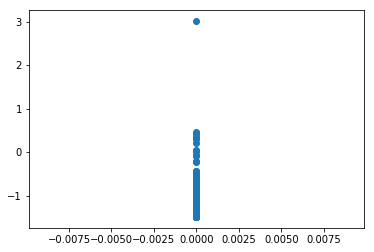

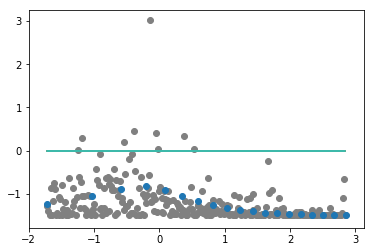

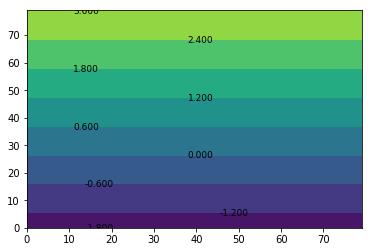

  215| 11|18177.238|17325.521|  851.717|1673075.500|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.016|    0.097|    0.000|    1.000
  430| 22| 7136.091| 6063.460| 1072.631|251460.094|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.023|    0.060|    0.000|    1.000
  645| 32| 4152.004| 2943.811| 1208.193|73567.328|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.023|    0.044|    0.000|    1.000
  860| 43| 2896.988| 1589.172| 1307.816|28645.574|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.021|    0.036|    0.000|    1.000
 1075| 54| 2252.831|  865.500| 1387.331|13572.770|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.020|    0.030|    0.000|    1.000
 1290| 64| 1881.325|  427.889| 1453.436| 7395.2

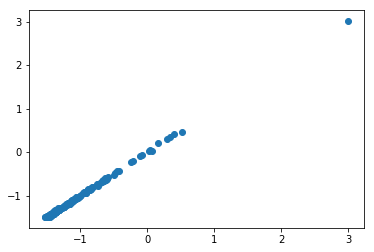

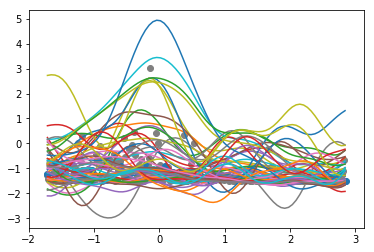

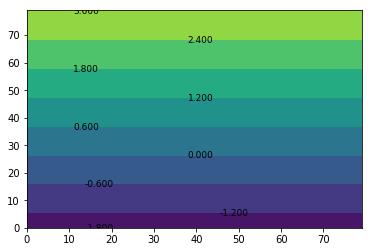

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 1357.396| -255.690| 1613.087|445830.781|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.010|    0.019|    0.000|    1.000


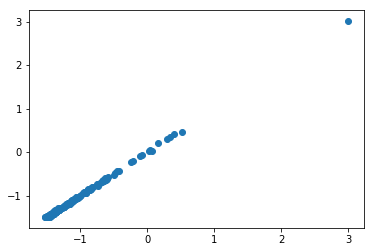

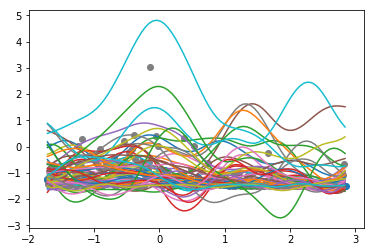

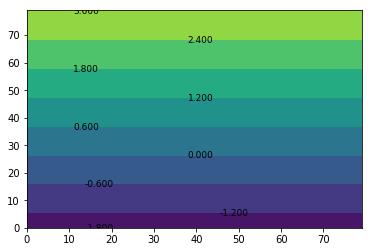

   35| 18| 1342.819| -277.453| 1620.272|14928.598|    2.000|    0.010|    0.500|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.009|    0.019|    0.000|    1.000
   70| 35| 1328.992| -298.554| 1627.546| 1943.847|    2.000|    0.010|    0.499|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.009|    0.018|    0.000|    1.000
  105| 52| 1316.857| -317.814| 1634.671| 1479.312|    2.000|    0.010|    0.499|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.009|    0.018|    0.000|    1.000
  140| 70| 1303.960| -337.684| 1641.644| 1290.541|    2.000|    0.010|    0.499|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.008|    0.018|    0.000|    1.000
  175| 88| 1290.480| -357.979| 1648.459| 1377.588|    2.000|    0.010|    0.498|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.007|    0.017|    0.000|    1.000
  200|100| 1284.274| -368.953| 1653.227| 1804.373|

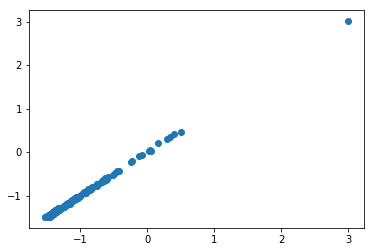

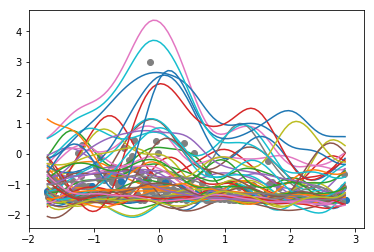

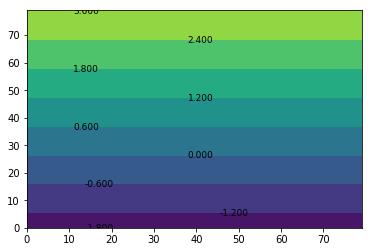

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 1281.064| -372.353| 1653.416|25516.574|    2.000|    0.010|    0.498|    1.000|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.007|    0.017|    0.000|    1.000


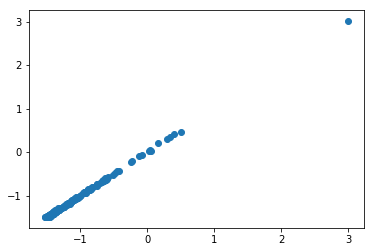

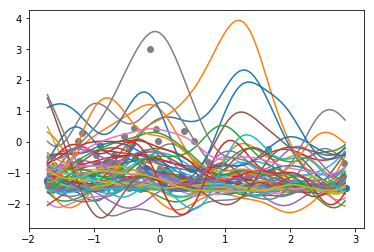

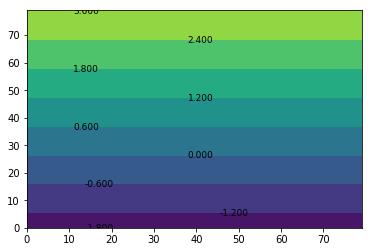

   35| 18| 1275.207| -385.342| 1660.550|12193.611|    2.000|    0.010|    0.498|    0.999|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.007|    0.017|    0.000|    1.000
   70| 35| 1265.462| -402.420| 1667.882| 2041.353|    2.000|    0.010|    0.498|    0.997|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.006|    0.017|    0.000|    1.000
  105| 52| 1254.776| -420.365| 1675.141| 1798.190|    2.000|    0.010|    0.498|    0.996|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.006|    0.016|    0.000|    1.000
  140| 70| 1244.928| -437.336| 1682.265| 1404.080|    2.000|    0.010|    0.498|    0.995|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.005|    0.016|    0.000|    1.000
  175| 88| 1236.158| -453.060| 1689.218| 1132.252|    2.000|    0.010|    0.498|    0.994|    1.414|    1.000|    0.500|    0.500|    0.500|    0.500|    0.005|    0.016|    0.000|    1.000
  200|100| 1230.409| -463.659| 1694.068| 1029.749|

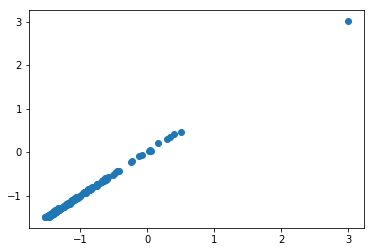

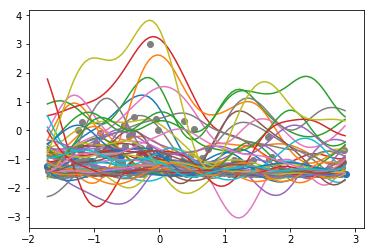

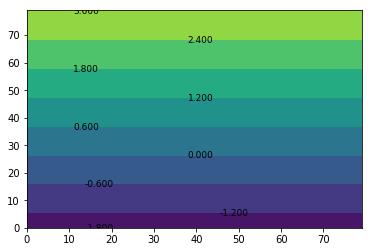

In [233]:
model.learn(X, XStar, T, Y, Z, n, N, Nmc, batch_size, 0, 0, 0, 0,
            verbose=3,learning_rate=10**(-3),optimisationDescription=optimisationDescription,
            saveStates=None,displayZlearn=True,displayYlearn=True,displayDef=True)#experimentFolder+'/results/states.pkl'
model.log_Y_noise_var.data = (noiseYsaveValue**2*torch.ones(model.Dout)).log().type(model.dtype)
if saveModelObj:
    with open(experimentFolder+'/results/startingModel.pkl', 'wb') as output:
        pickle.dump(model, output)

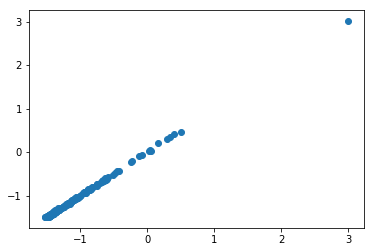

In [234]:
yy, yyv, zz, zzv = model.layers[0].predictGivenTheta(X,XStar,T,Nmc,theta_sample=None,forcePhiCompute=True)
plt.scatter(zz.squeeze().data.cpu().numpy(),Z.squeeze().data.cpu().numpy())

ani
Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)
initial Nelbo: 10000000000
New startpoints
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|99231.500|97526.977| 1704.527|    0.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.382|    0.506|    0.538|    0.010|    0.004|    0.016|    0.000|    1.000


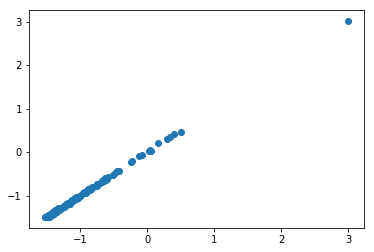

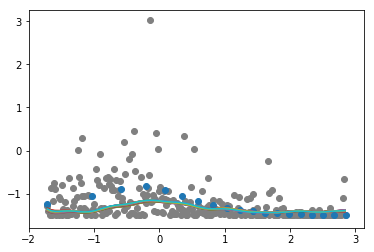

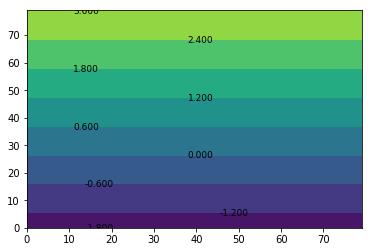

  250| 25|96427.391|94722.844| 1704.549|101025.664|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.351|    0.010|    0.004|    0.016|    0.000|    1.000
  500| 50|96427.898|94723.352| 1704.550|19042.891|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
  750| 75|96428.773|94724.227| 1704.550|289207.438|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.459|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
 1000|100|96430.055|94725.508| 1704.548|257685.031|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.352|    0.010|    0.004|    0.016|    0.000|    1.000
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96432.094|94727.547| 1704.547|206881.859

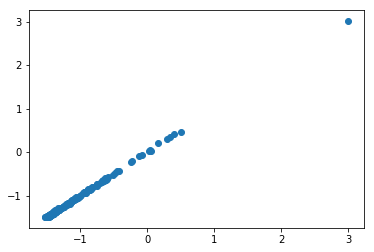

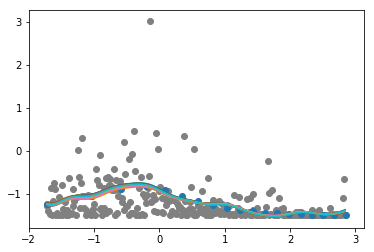

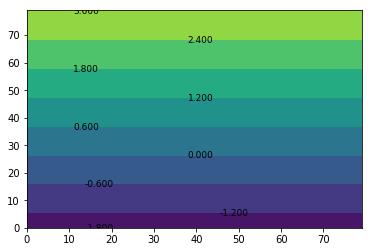

   73| 29|96424.617|94719.148| 1705.466| 9028.994|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.349|    0.007|    0.004|    0.016|    0.000|    1.000
  146| 58|96422.602|94716.508| 1706.092|281643.938|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.346|    0.006|    0.004|    0.016|    0.000|    1.000
  219| 88|96421.602|94715.078| 1706.523|  825.226|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.459|    0.349|    0.005|    0.004|    0.016|    0.000|    1.000
  250|100|96422.172|94715.508| 1706.665|24920.576|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.000|    1.000


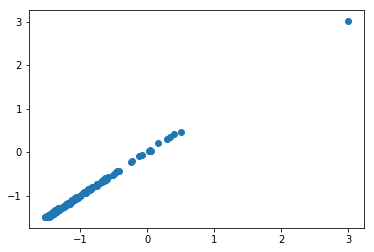

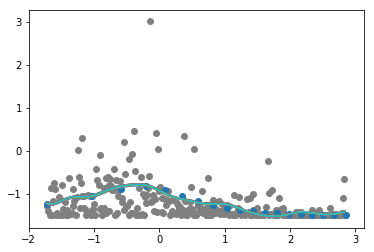

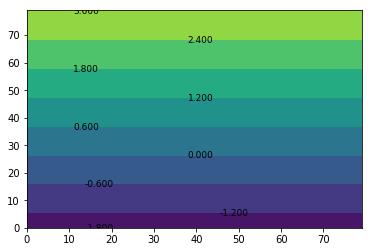

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96423.375|94716.703| 1706.669|27736646.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.000|    1.000


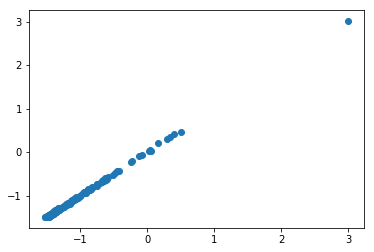

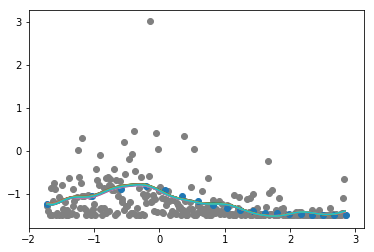

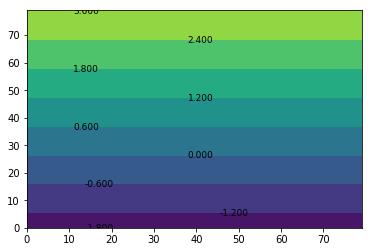

 1940| 19| 2935.863|  534.495| 2401.368|210892.297|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|   -0.001|    0.110
 3880| 39| 2433.076| -189.818| 2622.894|60260.930|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.001|    0.063
 5820| 58| 2396.975| -317.201| 2714.176|485230.312|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.001|    0.050
 7760| 78| 2395.193| -334.269| 2729.462|91304.750|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
 9700| 97| 2395.135| -334.586| 2729.721|47006.473|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
10000|100| 2398.304| -331.424| 2729.727|1292857.

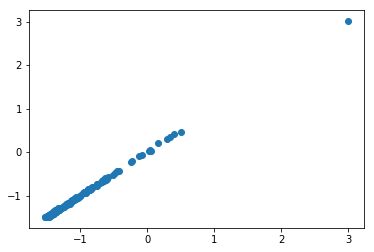

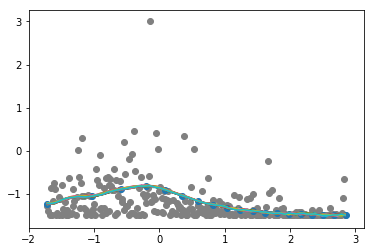

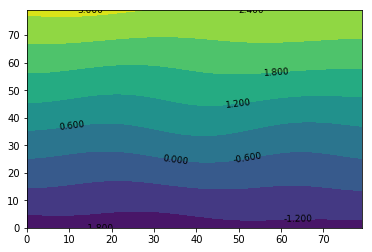

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 2399.999| -329.728| 2729.727|973294.250|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048


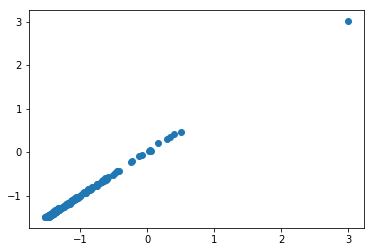

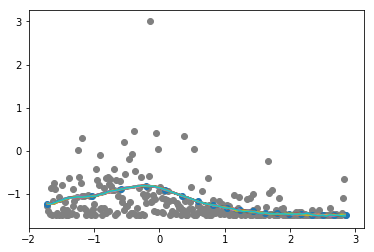

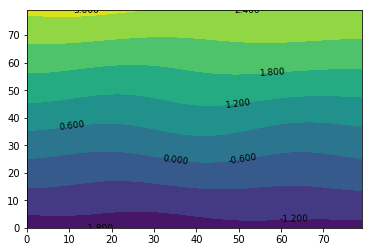

 1940| 19| 2306.446| -423.281| 2729.727|16264.583|    0.010|    0.010|    0.498|    0.993|    1.414|    0.595|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
 3880| 39| 2305.991| -423.736| 2729.727| 6295.600|    0.010|    0.010|    0.498|    0.993|    1.414|    0.545|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
 5820| 58| 2305.421| -424.305| 2729.727| 2419.500|    0.010|    0.010|    0.498|    0.993|    1.414|    0.544|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
 7760| 78| 2305.440| -424.286| 2729.727|  426.669|    0.010|    0.010|    0.498|    0.993|    1.414|    0.544|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
 9700| 97| 2306.628| -423.099| 2729.727|  365.364|    0.010|    0.010|    0.498|    0.993|    1.414|    0.544|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.002|    0.048
10000|100| 2305.956| -423.771| 2729.727|17538.043|

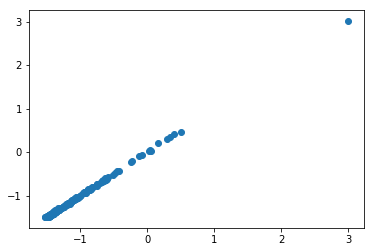

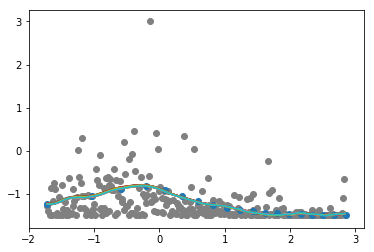

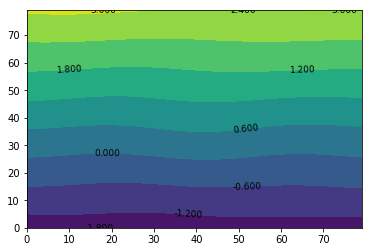

New record!
New startpoints
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|113139.398|111434.508| 1704.894|    0.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.589|    0.150|    0.239|    0.010|    0.004|    0.016|    0.000|    1.000


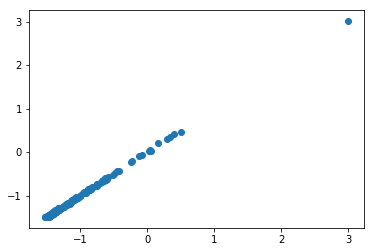

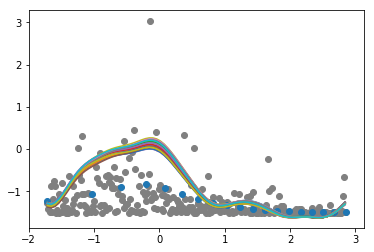

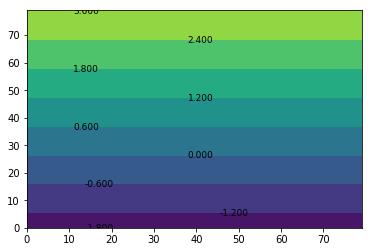

  250| 25|96436.984|94732.438| 1704.544|602171.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.452|    0.362|    0.010|    0.004|    0.016|    0.000|    1.000
  500| 50|96428.438|94723.891| 1704.549|72472.203|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.459|    0.351|    0.010|    0.004|    0.016|    0.000|    1.000
  750| 75|96429.828|94725.281| 1704.549|45331.617|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.351|    0.010|    0.004|    0.016|    0.000|    1.000
 1000|100|96429.625|94725.078| 1704.549|15956.586|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96432.094|94727.547| 1704.549|15173.384|  

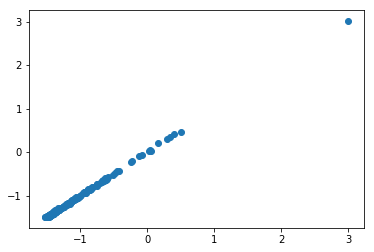

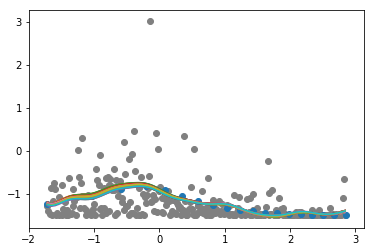

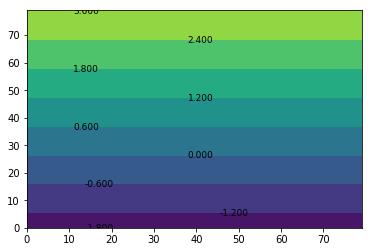

   73| 29|96426.383|94720.938| 1705.447|508442.438|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.547|    0.460|    0.351|    0.007|    0.004|    0.016|    0.000|    1.000
  146| 58|96423.352|94717.281| 1706.067|42374.840|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.459|    0.349|    0.006|    0.004|    0.016|    0.000|    1.000
  219| 88|96422.352|94715.867| 1706.487| 5709.169|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.349|    0.005|    0.004|    0.016|    0.000|    1.000
  250|100|96421.664|94715.047| 1706.617|98488.789|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|    0.000|    1.000


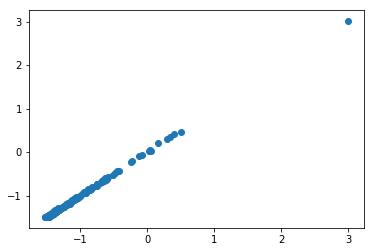

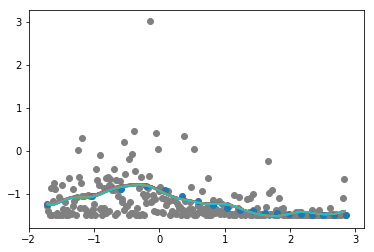

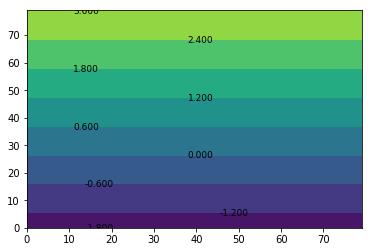

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96423.141|94716.516| 1706.622|27654612.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|    0.000|    1.000


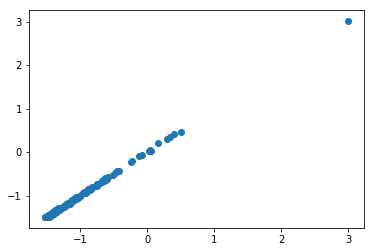

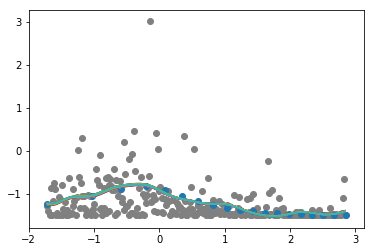

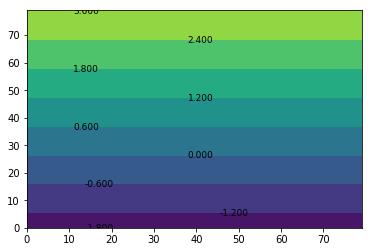

 1940| 19| 2933.923|  532.085| 2401.838|86258.102|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.004|    0.110
 3880| 39| 2437.048| -186.356| 2623.404|1511403.875|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.003|    0.063
 5820| 58| 2397.174| -317.080| 2714.253|425627.969|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.003|    0.050
 7760| 78| 2395.319| -334.062| 2729.381|106939.336|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
 9700| 97| 2394.769| -334.842| 2729.611|65313.648|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
10000|100| 2397.328| -332.285| 2729.613|621424

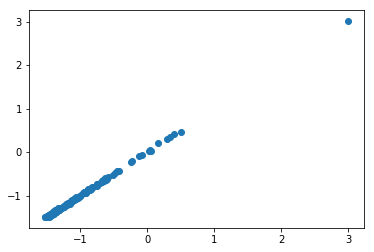

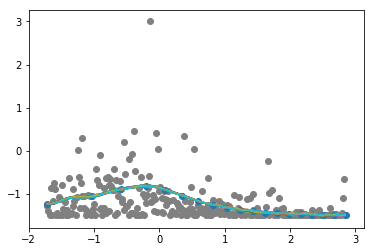

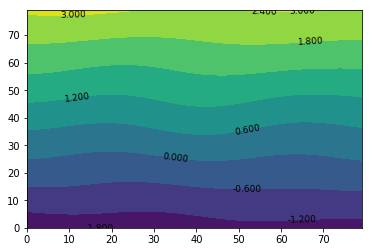

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 2400.786| -328.826| 2729.613|1206177.250|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048


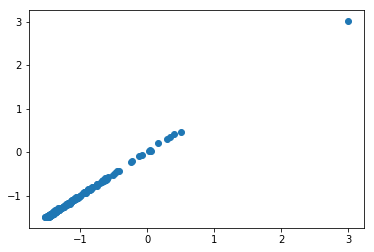

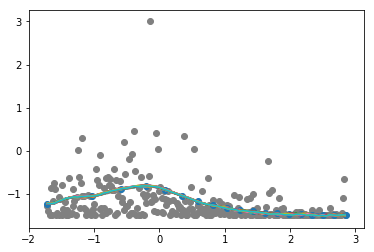

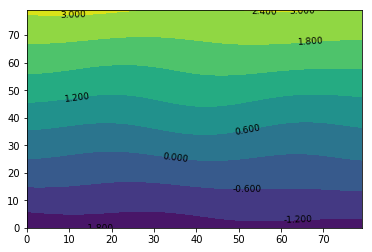

 1940| 19| 2306.053| -423.560| 2729.613| 2019.014|    0.010|    0.010|    0.498|    0.993|    1.414|    0.594|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
 3880| 39| 2308.773| -420.840| 2729.613| 3518.446|    0.010|    0.010|    0.498|    0.993|    1.414|    0.544|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
 5820| 58| 2306.503| -423.110| 2729.613| 3424.708|    0.010|    0.010|    0.498|    0.993|    1.414|    0.543|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
 7760| 78| 2306.013| -423.600| 2729.613|23697.936|    0.010|    0.010|    0.498|    0.993|    1.414|    0.543|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
 9700| 97| 2307.516| -422.097| 2729.613|   92.749|    0.010|    0.010|    0.498|    0.993|    1.414|    0.543|    0.549|    0.458|    0.348|    0.005|    0.004|    0.016|   -0.002|    0.048
10000|100| 2307.371| -422.242| 2729.613|13484.441|

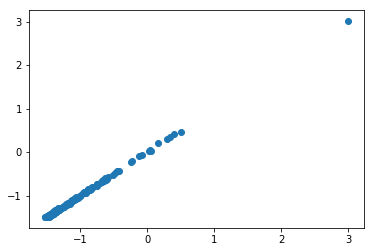

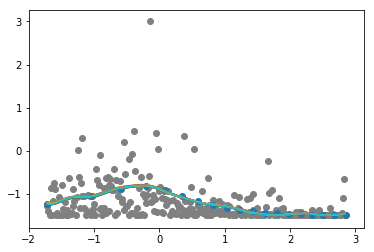

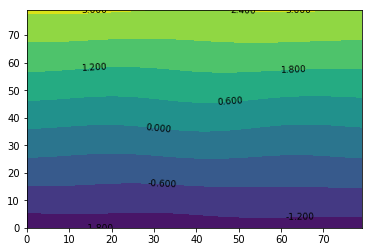

New startpoints
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|97128.609|95424.055| 1704.558|    0.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.671|    0.527|    0.468|    0.010|    0.004|    0.016|    0.000|    1.000


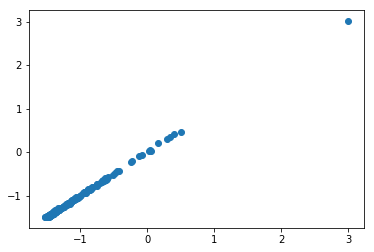

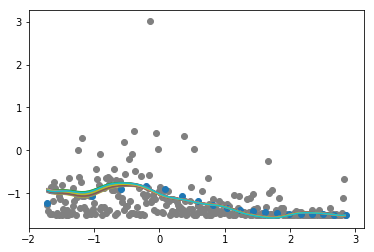

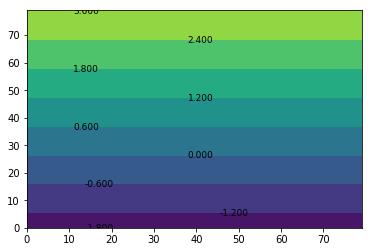

  250| 25|96431.742|94727.195| 1704.548|32795.852|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.459|    0.352|    0.010|    0.004|    0.016|    0.000|    1.000
  500| 50|96428.609|94724.062| 1704.550|82769.141|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.457|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
  750| 75|96426.992|94722.445| 1704.547|16352.193|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.461|    0.353|    0.010|    0.004|    0.016|    0.000|    1.000
 1000|100|96429.297|94724.742| 1704.552|60998.125|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.457|    0.348|    0.010|    0.004|    0.016|    0.000|    1.000
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96433.305|94728.750| 1704.552|930099.625|  

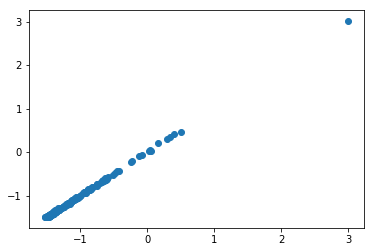

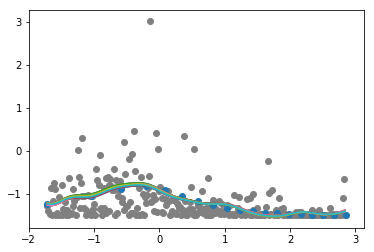

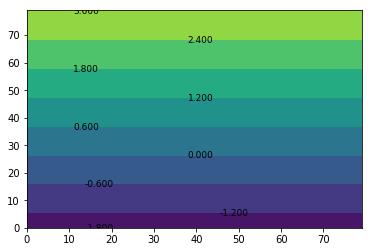

   73| 29|96426.391|94720.961| 1705.429|208711.938|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.349|    0.007|    0.004|    0.016|    0.000|    1.000
  146| 58|96423.742|94717.695| 1706.044|91660.398|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.349|    0.006|    0.004|    0.016|    0.000|    1.000
  219| 88|96422.367|94715.883| 1706.484| 1967.241|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.459|    0.350|    0.005|    0.004|    0.016|    0.000|    1.000
  250|100|96422.016|94715.391| 1706.628|68962.406|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.005|    0.004|    0.016|    0.000|    1.000


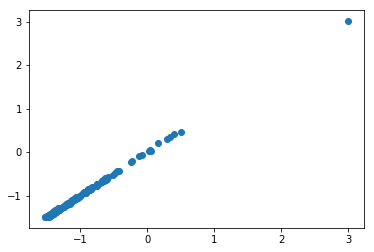

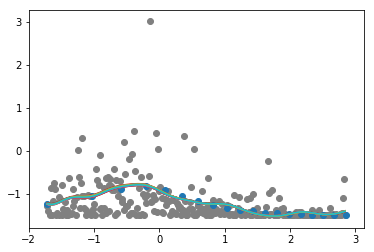

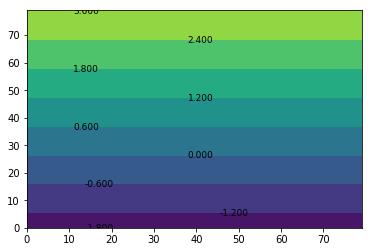

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96421.742|94715.109| 1706.631|28602060.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.000|    1.000


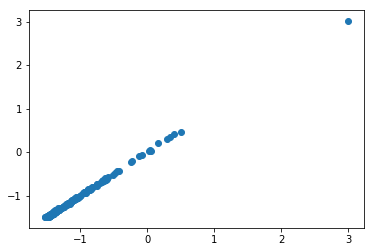

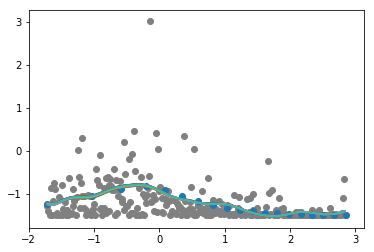

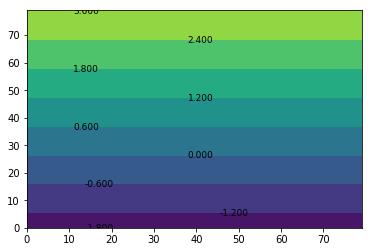

 1940| 19| 2937.684|  537.738| 2399.945|125206.695|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.000|    0.110
 3880| 39| 2432.598| -189.397| 2621.995|67747.344|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.000|    0.063
 5820| 58| 2393.623| -319.448| 2713.071|12664.261|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.001|    0.050
 7760| 78| 2395.207| -332.869| 2728.077|170084.109|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.001|    0.048
 9700| 97| 2392.742| -335.610| 2728.352|22937.068|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048
10000|100| 2393.430| -334.919| 2728.348|40645.97

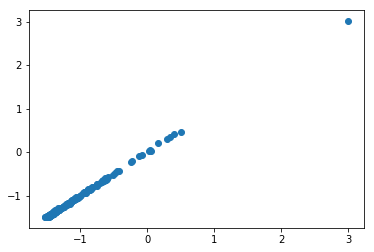

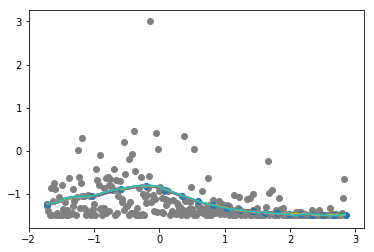

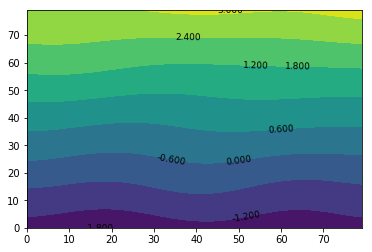

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 2393.962| -334.386| 2728.348|318785.344|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048


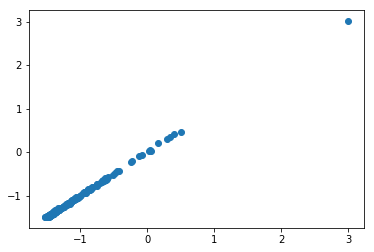

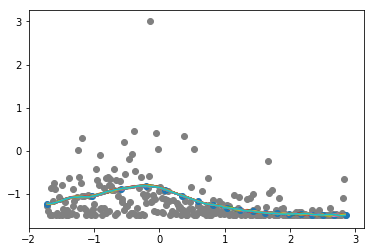

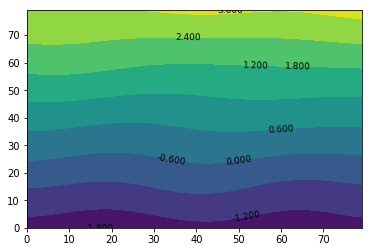

 1940| 19| 2303.890| -424.458| 2728.348| 2393.437|    0.010|    0.010|    0.498|    0.993|    1.414|    0.596|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048
 3880| 39| 2303.349| -424.999| 2728.348|13345.085|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048
 5820| 58| 2303.012| -425.336| 2728.348| 5040.993|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048
 7760| 78| 2303.441| -424.907| 2728.348| 9299.490|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048
 9700| 97| 2301.319| -427.029| 2728.348| 7912.312|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.351|    0.005|    0.004|    0.016|    0.002|    0.048
10000|100| 2301.620| -426.728| 2728.348| 1055.605|

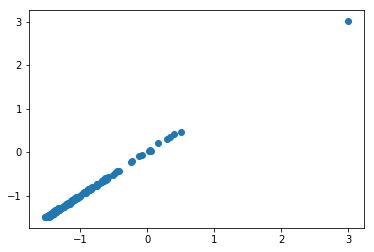

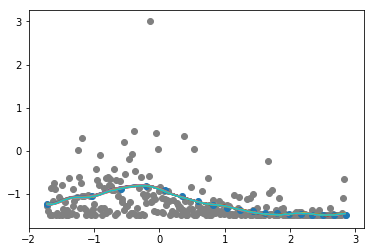

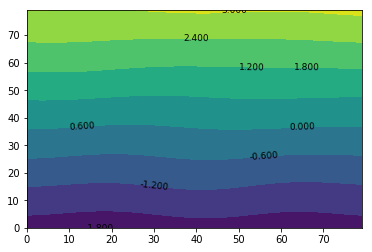

New record!
New startpoints
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|139868.922|138162.797| 1706.125|    0.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.345|   -0.364|    0.708|    0.010|    0.004|    0.016|    0.000|    1.000


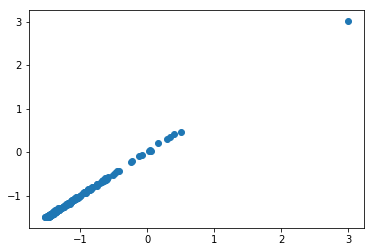

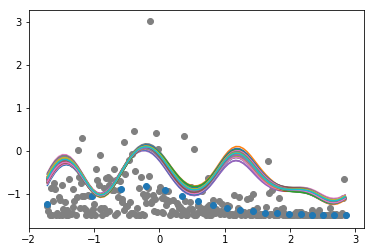

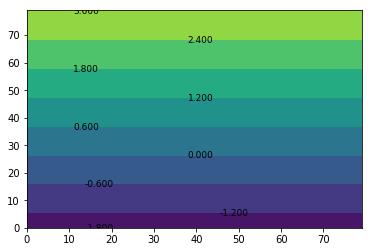

  250| 25|97214.000|95508.859| 1705.137|1066827.625|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.349|   -0.037|    0.597|    0.010|    0.004|    0.016|    0.000|    1.000
  500| 50|97218.953|95513.820| 1705.136|309531.750|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.349|   -0.036|    0.598|    0.010|    0.004|    0.016|    0.000|    1.000
  750| 75|97220.703|95515.570| 1705.136|96773.719|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.349|   -0.036|    0.599|    0.010|    0.004|    0.016|    0.000|    1.000
 1000|100|97219.492|95514.359| 1705.136|2112310.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.348|   -0.036|    0.599|    0.010|    0.004|    0.016|    0.000|    1.000
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|97215.742|95510.609| 1705.136|1393829.

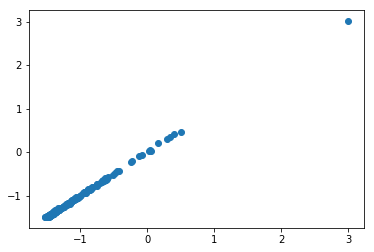

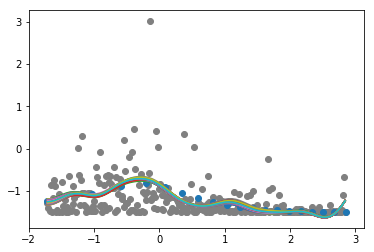

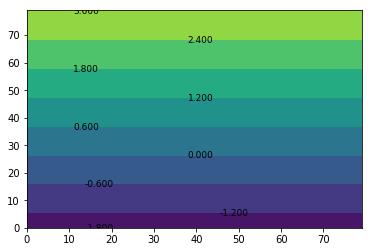

   73| 29|97202.625|95496.531| 1706.093|652096.562|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.349|   -0.036|    0.597|    0.007|    0.004|    0.016|    0.000|    1.000
  146| 58|97198.391|95491.586| 1706.803|88997.445|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.349|   -0.038|    0.596|    0.006|    0.004|    0.016|    0.000|    1.000
  219| 88|97193.812|95486.492| 1707.324|318209.344|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.347|   -0.038|    0.596|    0.005|    0.004|    0.016|    0.000|    1.000
  250|100|97190.992|95483.492| 1707.502|182888.734|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.037|    0.597|    0.005|    0.004|    0.016|    0.000|    1.000


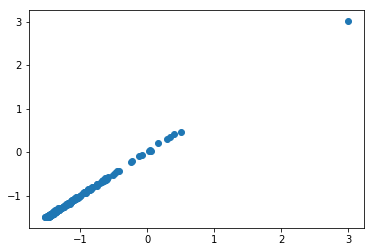

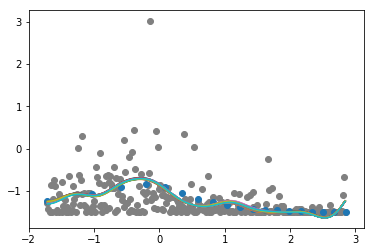

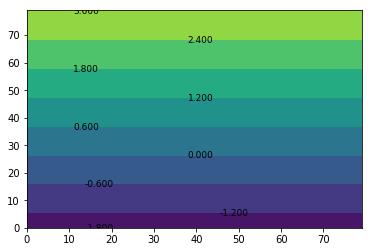

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|97193.031|95485.523| 1707.507|53519048.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|    0.000|    1.000


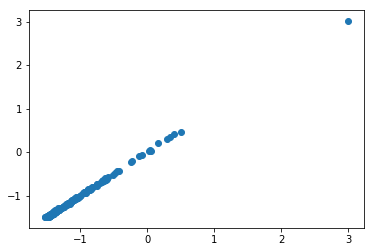

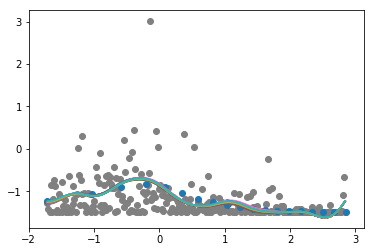

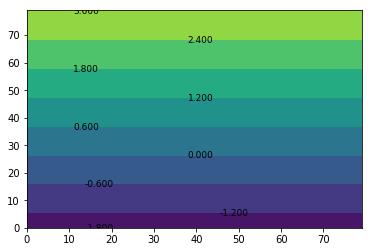

 1940| 19| 2937.834|  534.901| 2402.933|192462.609|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.002|    0.109
 3880| 39| 2437.269| -187.010| 2624.280|151094.109|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.003|    0.063
 5820| 58| 2398.783| -316.629| 2715.412|55008.613|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.050
 7760| 78| 2399.475| -331.147| 2730.622|868250.562|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
 9700| 97| 2398.676| -332.201| 2730.876|338519.656|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
10000|100| 2399.073| -331.809| 2730.882|549481

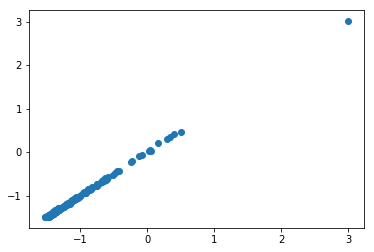

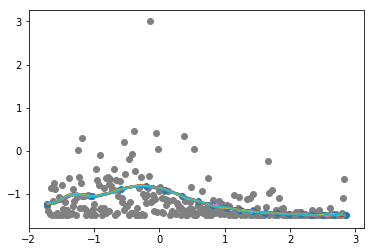

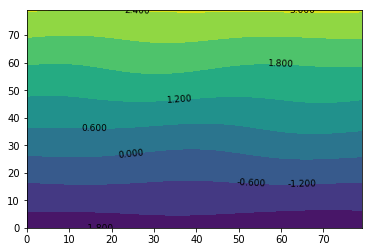

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 2399.931| -330.950| 2730.882|301742.969|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048


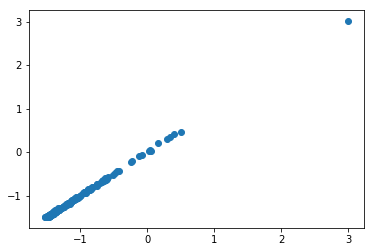

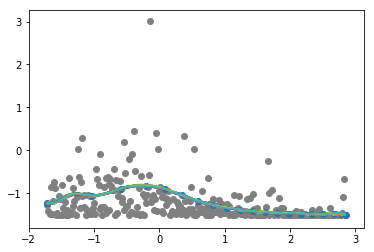

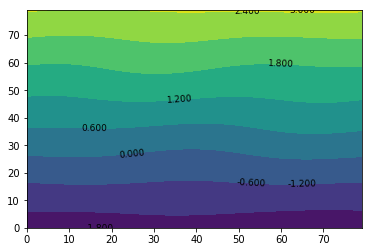

 1940| 19| 2361.072| -369.810| 2730.882|17886.965|    0.010|    0.010|    0.498|    0.993|    1.414|    0.817|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
 3880| 39| 2360.652| -370.230| 2730.882|10917.831|    0.010|    0.010|    0.498|    0.993|    1.414|    0.817|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
 5820| 58| 2362.498| -368.384| 2730.882| 7654.931|    0.010|    0.010|    0.498|    0.993|    1.414|    0.817|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
 7760| 78| 2361.616| -369.266| 2730.882|  370.232|    0.010|    0.010|    0.498|    0.993|    1.414|    0.818|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
 9700| 97| 2360.113| -370.769| 2730.882|17092.551|    0.010|    0.010|    0.498|    0.993|    1.414|    0.818|    0.350|   -0.036|    0.597|    0.005|    0.004|    0.016|   -0.004|    0.048
10000|100| 2361.191| -369.691| 2730.882| 2193.113|

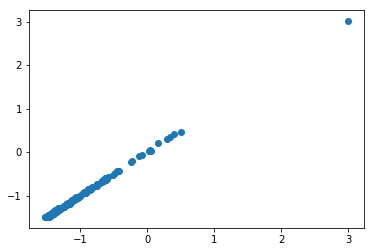

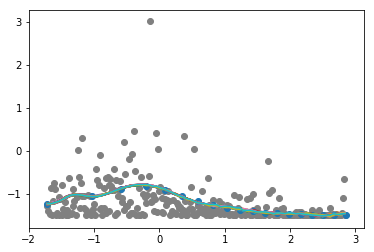

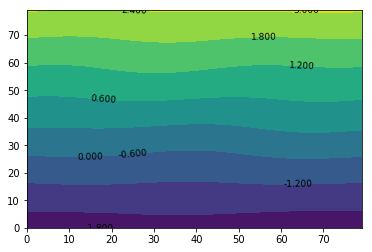

New startpoints
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|101573.312|99868.445| 1704.870|    0.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.321|    0.726|    0.178|    0.010|    0.004|    0.016|    0.000|    1.000


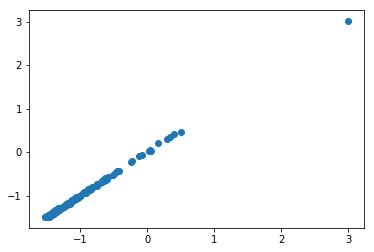

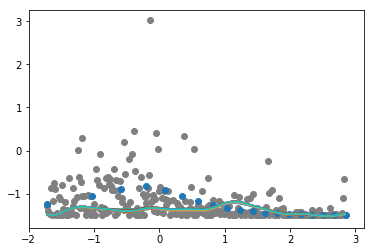

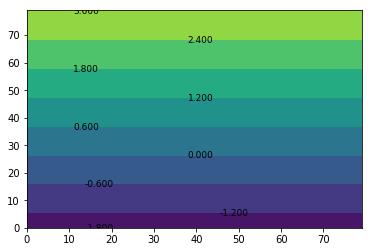

  250| 25|96432.883|94728.336| 1704.550|333708.719|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.010|    0.004|    0.016|    0.000|    1.000
  500| 50|96435.219|94730.672| 1704.551|143300.453|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.348|    0.010|    0.004|    0.016|    0.000|    1.000
  750| 75|96434.133|94729.586| 1704.550| 3212.347|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.010|    0.004|    0.016|    0.000|    1.000
 1000|100|96433.562|94729.016| 1704.550|21234.012|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.459|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96428.133|94723.586| 1704.551|82253.609| 

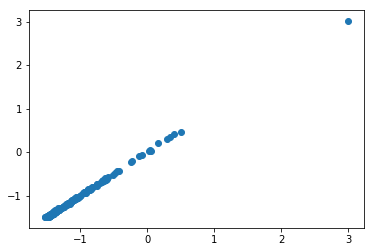

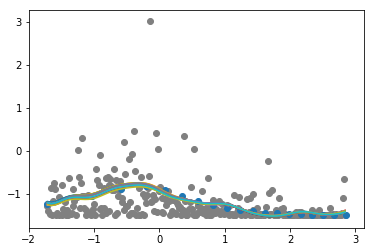

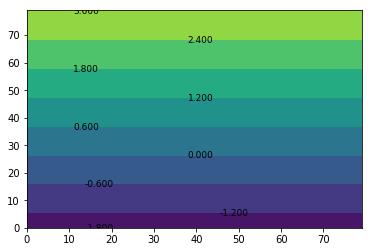

   73| 29|96424.469|94719.000| 1705.467|113310.508|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.350|    0.007|    0.004|    0.016|    0.000|    1.000
  146| 58|96423.625|94717.531| 1706.097|93668.398|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.350|    0.006|    0.004|    0.016|    0.000|    1.000
  219| 88|96422.547|94716.031| 1706.516|368763.188|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.460|    0.351|    0.005|    0.004|    0.016|    0.000|    1.000
  250|100|96421.578|94714.898| 1706.679|15936.058|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.348|    0.005|    0.004|    0.016|    0.000|    1.000


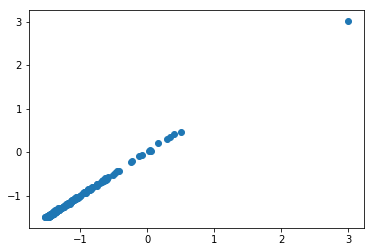

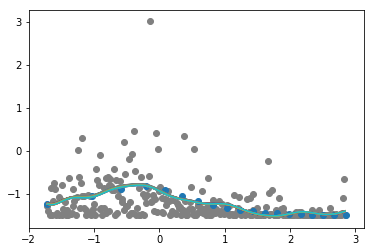

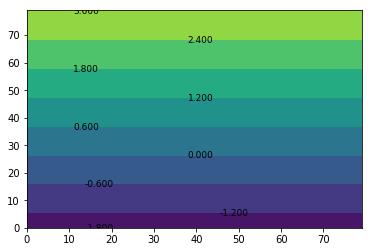

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96421.922|94715.242| 1706.682|28140504.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.000|    1.000


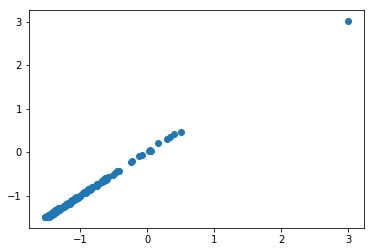

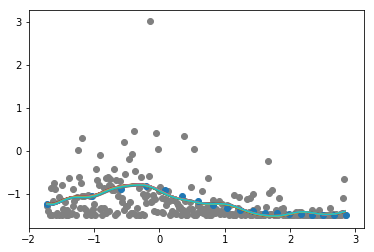

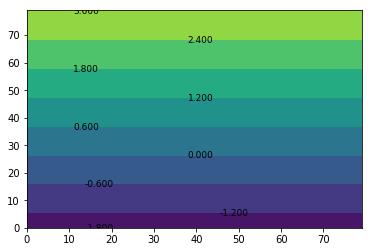

 1940| 19| 2932.722|  532.243| 2400.479|86499.281|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.110
 3880| 39| 2432.782| -189.058| 2621.840|152092.109|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.003|    0.063
 5820| 58| 2394.879| -318.055| 2712.934|288694.344|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.003|    0.050
 7760| 78| 2394.240| -333.926| 2728.165|437085.438|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
 9700| 97| 2393.718| -334.688| 2728.406|73790.078|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
10000|100| 2393.586| -334.820| 2728.407|193094.

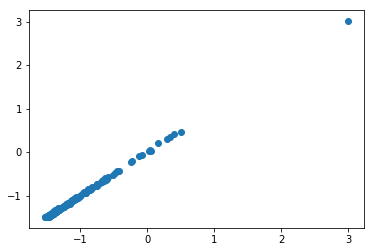

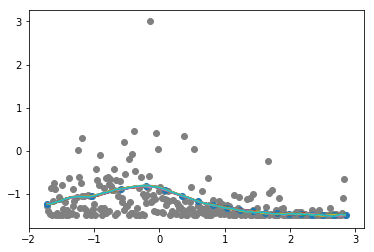

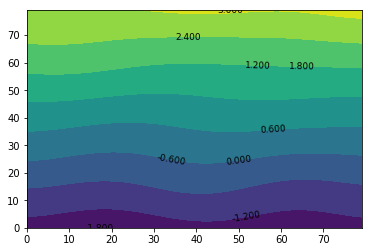

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 2393.575| -334.832| 2728.406|152851.938|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048


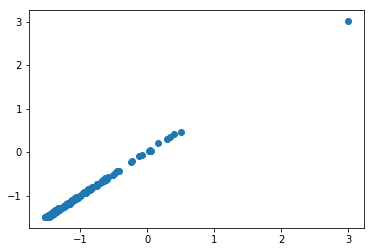

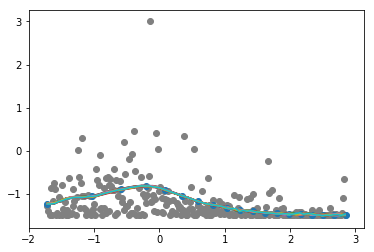

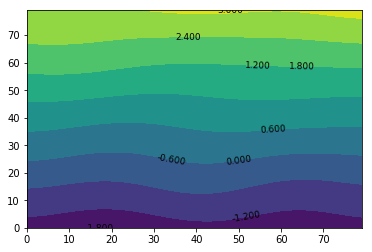

 1940| 19| 2305.220| -423.187| 2728.406| 5595.029|    0.010|    0.010|    0.498|    0.993|    1.414|    0.596|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
 3880| 39| 2302.668| -425.738| 2728.406| 7183.339|    0.010|    0.010|    0.498|    0.993|    1.414|    0.549|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
 5820| 58| 2304.188| -424.218| 2728.406|35384.242|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
 7760| 78| 2302.938| -425.469| 2728.406|15048.961|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
 9700| 97| 2303.943| -424.464| 2728.406| 8271.366|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.549|    0.460|    0.349|    0.005|    0.004|    0.016|    0.002|    0.048
10000|100| 2303.885| -424.521| 2728.406|11446.424|

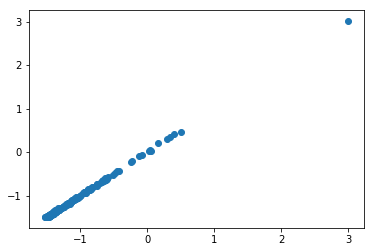

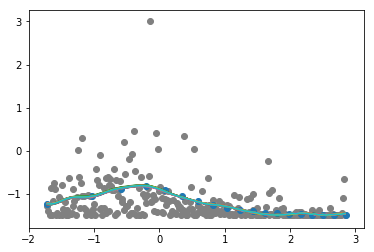

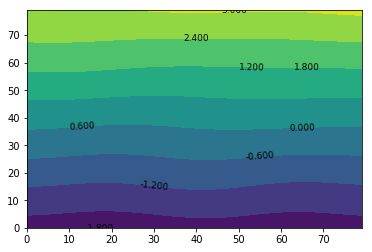

New startpoints
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|106394.727|104689.727| 1704.998|    0.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.275|    0.844|    0.787|    0.010|    0.004|    0.016|    0.000|    1.000


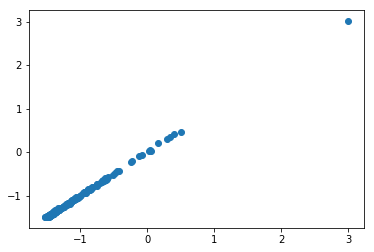

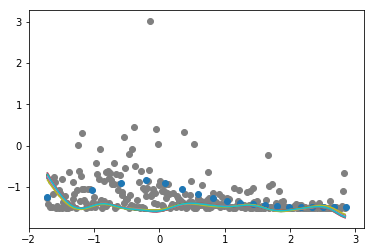

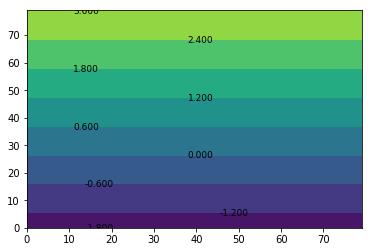

  250| 25|96429.930|94725.383| 1704.550|216652.828|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.458|    0.349|    0.010|    0.004|    0.016|    0.000|    1.000
  500| 50|96430.336|94725.789| 1704.550|387411.188|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.459|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
  750| 75|96430.750|94726.203| 1704.548|19625.119|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.460|    0.352|    0.010|    0.004|    0.016|    0.000|    1.000
 1000|100|96428.180|94723.633| 1704.549|150513.891|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.549|    0.459|    0.350|    0.010|    0.004|    0.016|    0.000|    1.000
 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96431.641|94727.094| 1704.549|77218.320|

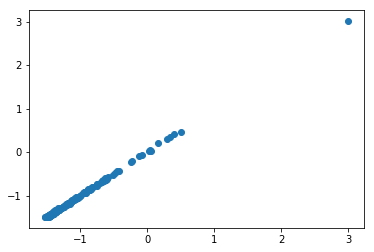

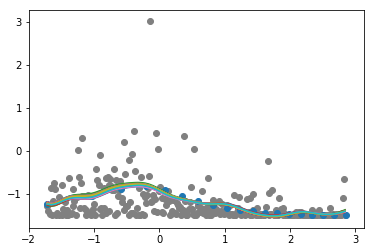

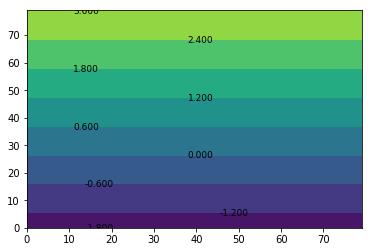

   73| 29|96424.773|94719.328| 1705.448|737037.625|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.551|    0.458|    0.347|    0.007|    0.004|    0.016|    0.000|    1.000
  146| 58|96425.062|94718.984| 1706.080|291806.750|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.548|    0.460|    0.352|    0.006|    0.004|    0.016|    0.000|    1.000
  219| 88|96423.750|94717.234| 1706.513|538013.438|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.551|    0.458|    0.348|    0.005|    0.004|    0.016|    0.000|    1.000
  250|100|96422.375|94715.727| 1706.652|101237.227|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.000|    1.000


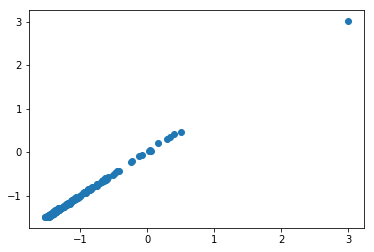

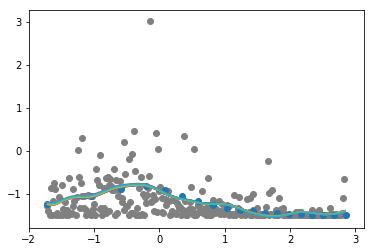

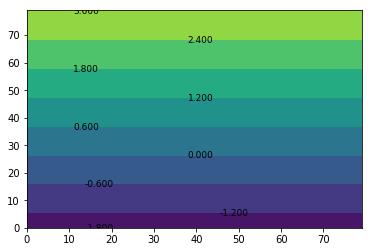

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0|96421.461|94714.805| 1706.656|28008902.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.000|    1.000


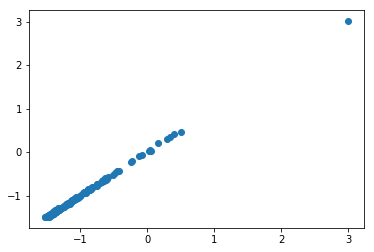

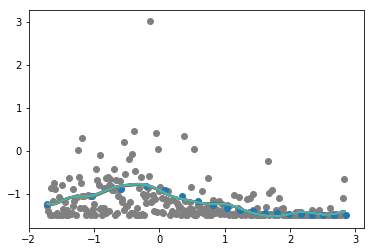

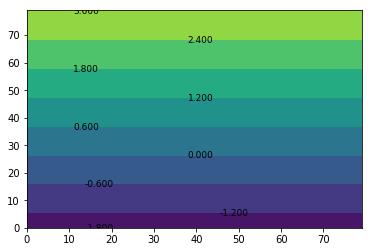

 1940| 19| 2935.186|  532.975| 2402.211|346902.969|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.110
 3880| 39| 2434.439| -188.986| 2623.425|315330.000|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.004|    0.063
 5820| 58| 2394.311| -319.478| 2713.789|32116.510|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.004|    0.050
 7760| 78| 2394.965| -333.625| 2728.590|544571.812|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.004|    0.048
 9700| 97| 2393.516| -335.078| 2728.594|179618.906|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048
10000|100| 2394.419| -334.137| 2728.557|407394

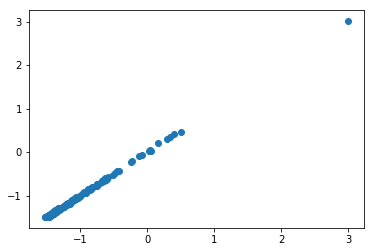

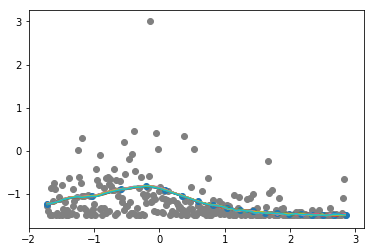

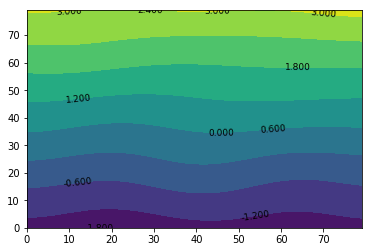

 Ite | % |   NLB   |   NLL   |   DKL   |   GdN   |   NsY   |   NsZ   |   Ret   |   Set   |   Rdl   |   Sdl   |   Mth   |   Mth   |   Mth   |   Sth   |   MWE   |   SWE   |   MWD   |   SWD
    0|  0| 2393.185| -335.371| 2728.556|208760.938|    0.010|    0.010|    0.498|    0.993|    1.414|    1.000|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048


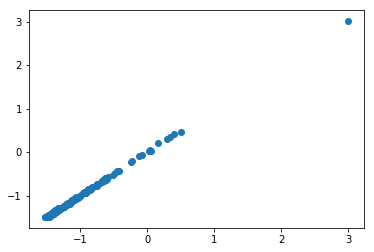

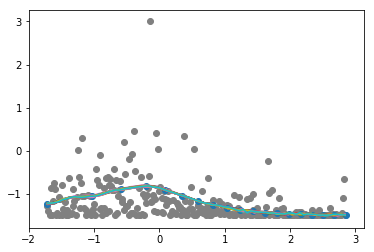

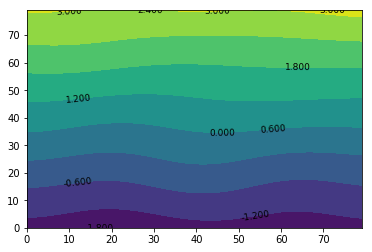

 1940| 19| 2303.560| -424.996| 2728.556| 4574.528|    0.010|    0.010|    0.498|    0.993|    1.414|    0.596|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048
 3880| 39| 2301.659| -426.897| 2728.556|  603.733|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048
 5820| 58| 2302.832| -425.724| 2728.556|12557.272|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048
 7760| 78| 2301.759| -426.797| 2728.556| 5167.175|    0.010|    0.010|    0.498|    0.993|    1.414|    0.548|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048
 9700| 97| 2301.364| -427.191| 2728.556| 5408.033|    0.010|    0.010|    0.498|    0.993|    1.414|    0.547|    0.550|    0.458|    0.349|    0.005|    0.004|    0.016|    0.003|    0.048
10000|100| 2303.756| -424.800| 2728.556| 8618.837|

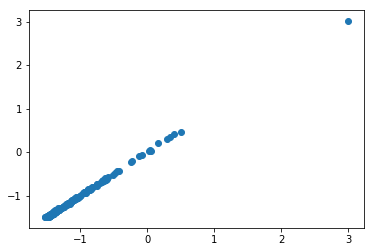

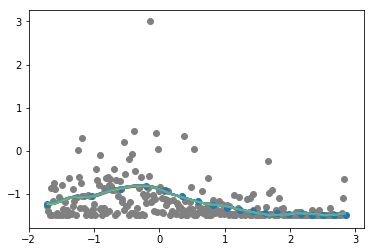

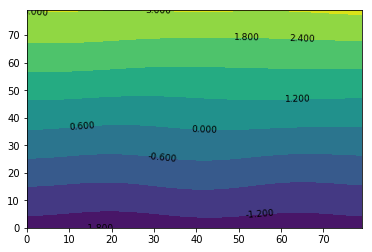

In [235]:
if not additiveDiscr:
    if model.kernel_ard:
        model.layers[0].etaAnisotropy.requires_grad=False
    else:
        model.layers[0].etaAnisotropy.requires_grad=True
print("ani")
print(model.layers[0].etaAnisotropy)
nbStarts = 6#2*D2
#modelLog_Y_noise_varSave = model.log_Y_noise_var.data.clone()
#model.log_Y_noise_var.data = (0.1**2*torch.ones(model.Dout)).log().type(model.dtype)

#model.compute_nelbo(X,XStar,T, Y, Z, Nmc, n, N, batch_size=N)
bestPerf=10000000000
print("initial Nelbo: "+str(bestPerf))
#model.log_Y_noise_var.data = modelLog_Y_noise_varSave
saveTheta_m = model.layers[0].q_theta_m.data.clone()
saveTheta_logv = model.layers[0].q_theta_logv.data.clone()

results = torch.zeros(nbStarts,2*D2+1).type(dtype)

Nmc=50

optimisationDescription = torch.Tensor( # > 1 means fixed, even means display
[#0nIt     1learnRate 2NLB  3NLL, 4DKL, 5gdN, 6NsY, 7NsZ, 8Ret, 9Set,10Rdl,11Sdl,12Mth,13Sth 14 Mwe 15 Swe 16 Mwd 17 Swd
    [   1000  , 10**(-2),    0,   0 ,   0,    0,    2,    2,    2,    2,    2,    2,    0,    2, 2, 2, 2, 2],
    [    250  , 10**(-2),    0,   0 ,   0,    0,    2,    2,    2,    2,    2,    2,    0,    0, 2, 2, 2, 2],
    [  10000  , 10**(-2),    0,   0 ,   0,    0,    2,    2,    2,    2,    2,    2,    2,    2, 2, 2, 0, 0],
    [  10000  , 10**(-3),    0,   0 ,   0,    0,    2,    2,    2,    0,    2,    0,    2,    2, 2, 2, 2, 2]
    #[  100000 , 10**(-3),   0,   0 ,   0,    0,    2,    2,    0,    0,    0,    0,    0,    0, 0, 0, 0, 0]
]
)

for j in range(nbStarts):
    print("New startpoints")
    #with open(experimentFolder+'/results/startingModel.pkl', 'rb') as input:
    #    startingModel = pickle.load(input)
    model.layers[0].etaAnisotropy.data = torch.ones(1).type(dtype)
    model.layers[0].q_theta_m.data = torch.randn(D2).type(dtype)*.5*torch.diag(priorThetaCovRoot)+priorThetaMean
    model.layers[0].q_theta_logv.data = (0.01**2*torch.ones(D2)).log().type(dtype)
    model.layers[0].q_W_delta_m.data.zero_()  #  = torch.zeros_like(model.layers[0].prior_W_delta_m.data).type(dtype)
    model.layers[0].q_W_delta_logv.data.zero_()# = torch.zeros_like(model.layers[0].prior_W_delta_m.data).type(dtype)
    model.layers[0].log_delta_lengthscale.data = (deltaRangeSaved*torch.ones(1, 1).type(dtype)).log().type(model.dtype)
    model.layers[0].log_delta_sigma2.data = (deltaStdSaved**2*torch.ones(1, 1).type(dtype)).log().type(model.dtype)
    model.log_Y_noise_var.data = (0.01**2*torch.ones(model.Dout)).log().type(model.dtype)
    #startingModel.log_Y_noise_var.data = (0.1**2*torch.ones(model.Dout)).log().type(model.dtype)
    model.learn(X, XStar, T, Y, Z, n, N, Nmc, batch_size, 0, 0, 0, 0,
            verbose=2,learning_rate=10**(-3),optimisationDescription=optimisationDescription,
            saveStates=None,displayZlearn=True,displayYlearn=True,displayDef=True)
    perf = float(model.nelbo[0])
    results[j,0] = perf
    results[j,1:(D2+1)] = model.layers[0].q_theta_m.data.clone()
    results[j,(D2+1):(2*D2+1)] = model.layers[0].q_theta_logv.exp().sqrt().data.clone()
    if perf < bestPerf:
        print("New record!")
        bestPerf=perf
        saveBestTheta_m = model.layers[0].q_theta_m.data.clone()
        saveBestTheta_logv = model.layers[0].q_theta_logv.data.clone()
        saveBestMWd = model.layers[0].q_W_delta_m.clone()
        saveBestVWd = model.layers[0].q_W_delta_logv.clone()
        saveBestAni = model.layers[0].etaAnisotropy.data.clone()
        saveBestRd = model.layers[0].log_delta_lengthscale.data.clone()
        
#model.layers[0].q_theta_m.data = saveBestTheta_m
#model.layers[0].q_theta_logv.data = saveBestTheta_logv
if saveModelObj:
        with open(experimentFolder+'/results/bestModel.pkl', 'wb') as output:
                pickle.dump(model, output)
#model.log_Z_noise_var.data = (noiseZsaveValue**2*torch.ones(model.Dout)).log().type(model.dtype)

In [236]:
print(results)
model.layers[0].q_theta_m.data = saveBestTheta_m
model.layers[0].q_theta_logv.data = saveBestTheta_logv
model.layers[0].q_W_delta_m.data = saveBestMWd
model.layers[0].q_W_delta_logv.data = saveBestVWd
model.layers[0].etaAnisotropy.data = saveBestAni
model.layers[0].log_delta_lengthscale.data = saveBestRd

tensor([[ 2.3060e+03,  5.4905e-01,  4.5893e-01,  3.4988e-01,  4.6617e-03,
          4.9901e-03,  5.1615e-03],
        [ 2.3074e+03,  5.4922e-01,  4.5780e-01,  3.4823e-01,  4.6653e-03,
          5.0355e-03,  5.3643e-03],
        [ 2.3016e+03,  5.4863e-01,  4.5978e-01,  3.5100e-01,  4.7118e-03,
          4.9765e-03,  5.3151e-03],
        [ 2.3612e+03,  3.5042e-01, -3.6447e-02,  5.9738e-01,  4.5154e-03,
          4.5050e-03,  4.5891e-03],
        [ 2.3039e+03,  5.4853e-01,  4.6006e-01,  3.4919e-01,  4.5298e-03,
          4.9772e-03,  5.2555e-03],
        [ 2.3038e+03,  5.4956e-01,  4.5760e-01,  3.4932e-01,  4.6056e-03,
          4.9990e-03,  5.2837e-03]], device='cuda:0')


12.071345619360606


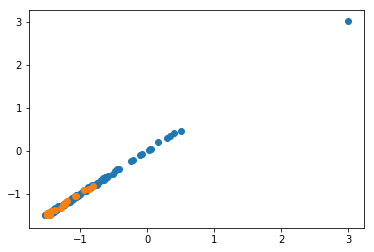

In [237]:
end = time.time()

print((end - start)/60)

ym,yv,zm,zv = model.layers[0].predictGivenTheta(X,XStar,T,Nmc,None,forcePhiCompute=True)

#model.layers[0].q_theta_m.data = saveBestTheta_m

plt.scatter(zm.squeeze().data.cpu().numpy(),Z.squeeze().cpu().numpy())
plt.scatter(ym.data.mean(0).squeeze().cpu().numpy(),Y.data.squeeze().cpu().numpy())
plt.show()

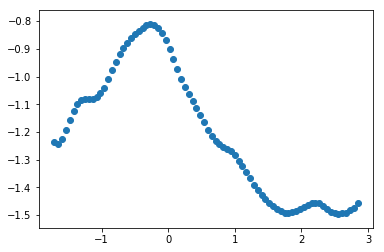

In [238]:
lowerDef = torch.tensor([Z.min(),XStar.min()]).type(dtype)
upperDef = torch.tensor([Z.max(),XStar.max()]).type(dtype)
axialPre = 80
actualGrid = (giveGrid(axialPre,1).type(model.dtype)*(upperDef[1]-lowerDef[1]).unsqueeze(0)+lowerDef[1].unsqueeze(0))
ym,yv,zm,zv = model.layers[0].predictGivenTheta(actualGrid,XStar,T,Nmc,None,forcePhiCompute=True)
plt.scatter(actualGrid.data.cpu().numpy(),ym.mean(0).squeeze().data.cpu().numpy())

In [239]:
#model.layers[0].etaAnisotropy.data[0] = torch.ones_like(model.layers[0].etaAnisotropy).type(dtype)
model.layers[0].etaAnisotropy.data[0].exp()

tensor(5.2039, device='cuda:0')

In [240]:
Z.min()

tensor(-1.5000, device='cuda:0')

<a list of 20 text.Text objects>

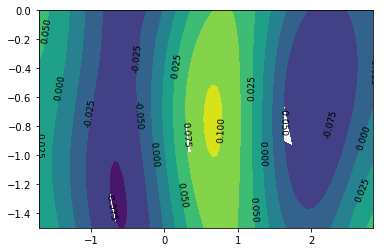

In [241]:
lowerDef = torch.tensor([Z.min(),XStar.min()]).type(dtype)
#upperDef = torch.tensor([Z.max(),XStar.max()]).type(dtype)
upperDef = torch.tensor([0,XStar.max()]).type(dtype)
axialPre = 80
actualGrid = (giveGrid(axialPre,D1+1).type(model.dtype)*(upperDef-lowerDef).unsqueeze(0)+lowerDef.unsqueeze(0)).squeeze()
Omega_delta_sample = torch.exp(-model.layers[0].log_delta_lengthscale)*2.**0.5*model.layers[0].epsilon_for_Omega_delta_sample
Phi_delta_before_activation=torch.matmul(actualGrid, Omega_delta_sample)
Phi_delta_noStd = torch.cat((torch.sin(Phi_delta_before_activation), torch.cos(Phi_delta_before_activation)), 1)
Phi_delta = Phi_delta_noStd * torch.sqrt(torch.exp(model.layers[0].log_delta_sigma2) / model.layers[0].NRFs)
mean_F_delta = torch.matmul(Phi_delta, model.layers[0].q_W_delta_m)
var_F_delta = torch.matmul(Phi_delta**2, torch.exp(model.layers[0].q_W_delta_logv))
defo = mean_F_delta#+actualGrid[:,0].unsqueeze(1)
CS = plt.contourf(np.linspace(lowerDef[1].item(),upperDef[1].item(),axialPre),np.linspace(lowerDef[0].item(),upperDef[0].item(),axialPre),defo.data.cpu().view(axialPre,axialPre))
plt.clabel(CS,fontsize=9, inline=1,colors="black")

In [247]:
x1 =(torch.ones(1)*(-1.5)).type(dtype)
x2 =(torch.ones(1)*(-.5)).type(dtype)
x3 =(torch.ones(1)*(2.5)).type(dtype)

XX = torch.cat((x1.unsqueeze(0),x2.unsqueeze(0),x3.unsqueeze(0)),0)
pb1,pb2,zmXX,zvXX = model.layers[0].predictGivenTheta(XX,XX,model.layers[0].q_theta_m.unsqueeze(0).expand(3,-1),Nmc,None,forcePhiCompute=True)

print(XX)
print(zmXX)
pb1.mean(0)

tensor([[-1.5000],
        [-0.5000],
        [ 2.5000]], device='cuda:0')
tensor([[-1.1761],
        [-0.8162],
        [-1.4790]], device='cuda:0', grad_fn=<MmBackward>)


tensor([[-1.1671],
        [-0.8445],
        [-1.4942]], device='cuda:0', grad_fn=<MeanBackward0>)

In [248]:
width=1
etaGrid = (giveGrid(axialPre,1).type(model.dtype)*(upperDef[0]-lowerDef[0]).unsqueeze(0)+lowerDef[0].unsqueeze(0))
etaGrid1 = etaGrid#((giveGrid(axialPre,1).type(model.dtype)-.5)*width)+zmXX[0].item()
etaGrid2 = etaGrid#((giveGrid(axialPre,1).type(model.dtype)-.5)*width)+zmXX[1].item()
etaGrid3 = etaGrid#((giveGrid(axialPre,1).type(model.dtype)-.5)*width)+zmXX[2].item()

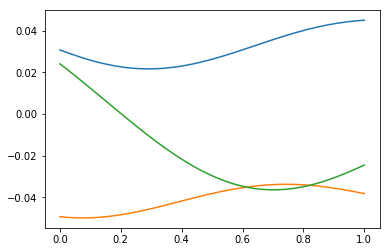

In [249]:
actualGrid = torch.cat((torch.cat((etaGrid1,x1.unsqueeze(0).expand(axialPre,-1)),1),torch.cat((etaGrid2,x2.unsqueeze(0).expand(axialPre,-1)),1),torch.cat((etaGrid3,x3.unsqueeze(0).expand(axialPre,-1)),1)),0)

Omega_delta_sample = torch.exp(-model.layers[0].log_delta_lengthscale)*2.**0.5*model.layers[0].epsilon_for_Omega_delta_sample
Phi_delta_before_activation=torch.matmul(actualGrid, Omega_delta_sample)
Phi_delta_noStd = torch.cat((torch.sin(Phi_delta_before_activation), torch.cos(Phi_delta_before_activation)), 1)
Phi_delta = Phi_delta_noStd * torch.sqrt(torch.exp(model.layers[0].log_delta_sigma2) / model.layers[0].NRFs)
mean_F_delta = torch.matmul(Phi_delta, model.layers[0].q_W_delta_m)
var_F_delta = torch.matmul(Phi_delta**2, torch.exp(model.layers[0].q_W_delta_logv))
plt.plot((giveGrid(axialPre,1).type(model.dtype)*width).squeeze().cpu().numpy(),(mean_F_delta[0:axialPre,:]).data.squeeze().cpu().numpy())
plt.plot((giveGrid(axialPre,1).type(model.dtype)*width).squeeze().cpu().numpy(),(mean_F_delta[axialPre:(2*axialPre),:]).data.squeeze().cpu().numpy())
plt.plot((giveGrid(axialPre,1).type(model.dtype)*width).squeeze().cpu().numpy(),(mean_F_delta[(2*axialPre):(3*axialPre),:]).data.squeeze().cpu().numpy())

In [245]:
#np.savetxt(experimentFolder+"/results/warping.csv",mean_F_delta.data.cpu().numpy(),delimiter=";")

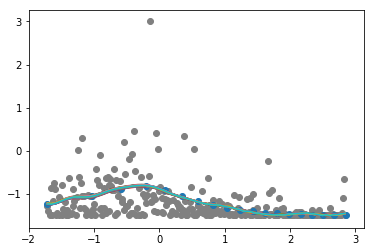

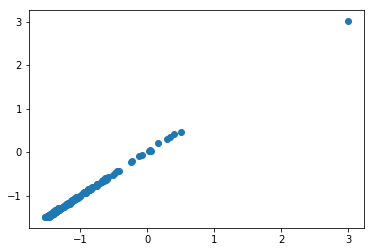

In [246]:
                            lower1 = torch.tensor([XStar.min(),XStar.min()]).type(model.dtype)
                            upper1 = torch.tensor([XStar.max(),XStar.max()]).type(model.dtype)
                            axialPre = 80
                            x = (giveGrid(axialPre,1).type(model.dtype)*(upper1[0]-lower1[0]).unsqueeze(0)+lower1[0].unsqueeze(0))
                            meanYGivenTheta,varYGivenTheta,meanZGivenTheta,varZGivenTheta =  model.forward(x, XStar[0:2,:], T[0:2,:], 50)
                            
                            plt.plot(x.squeeze().cpu().numpy(),meanYGivenTheta.data[:,:,0].t().squeeze().cpu().numpy())
                            plt.scatter(XStar.squeeze().cpu().numpy(),Z.squeeze().cpu().numpy(),c="gray")
                            plt.scatter(X.squeeze().cpu().numpy(),Y.squeeze().cpu().numpy())
                            plt.show()
                            if model.deepness>0:
                                print(model.layers[1].log_lengthscale.data.exp())
                                if model.deepness>1:
                                    print(model.layers[2].log_lengthscale.data.exp())
                            indices_batchplt = np.random.choice(N, np.min([N,1000]), replace=False)
                            yy, yyv, zz, zzv = model.forward(X[1:2,:],XStar[indices_batchplt,:],T[indices_batchplt,:],10)
                            if torch.cuda.is_available():
                                if len(zz.squeeze().size())==1:
                                    plt.scatter(zz.squeeze().data.cpu().numpy(),Z[indices_batchplt,:].squeeze().data.cpu().numpy())
                                else:
                                    plt.scatter(zz.squeeze().mean(0).data.cpu().numpy(),Z[indices_batchplt,:].squeeze().data.cpu().numpy())
                            else:
                                if len(zz.squeeze().size())==1:
                                    plt.scatter(zz.squeeze().data.numpy(),Z[indices_batchplt,:].squeeze().data.numpy())
                                else:
                                    plt.scatter(zz.squeeze().mean(0).data.numpy(),Z[indices_batchplt,:].squeeze().data.cpu().numpy())
                            plt.show()